## 數據處理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d



def load_data(file_path):
    """AG數據讀取"""
    AG_data = []
    with open(f'{file_path}.txt', 'r') as file:
        for line in file:
            if line.startswith("mcu:"):
                values = line.strip().split(",")[1:]
                AG_data.append([float(v) for v in values])

    """IQ數據讀取及時間標準化(以第一筆數據為0)"""
    IQ_data = pd.read_csv(f'{file_path}.csv')
    time_parts = IQ_data['Time'].str.split('-', expand=True).astype(float)
    IQ_data['time'] = time_parts[0] * 3600 + time_parts[1] * 60 + time_parts[2]
    IQ_data['time'] -= IQ_data['time'].iloc[0]
   
    return np.array(AG_data), IQ_data[['time', 'I', 'Q']]
    

def match_nearest_timepoint(df, total_points, interval=0.5, start_offset=0):
    """
    匹配最近的時間點數據

    參數:
    - df: DataFrame, 包含 'time'、'I' 和 'Q' 列的數據。
    - total_points: int, 資料總筆數, 即需要處理的數據點的數量。
    - interval: float, 資料間隔的時間長度, 預設為 0.5。
    - start_offset: int, 偏移量, 用於控制計算起始點的位置。

    返回:
    - np.array, 包含匹配最近時間點的 I 和 Q 值。
    """
    new_data = []
    for i in range(total_points):  # 資料總筆數
        target_time = (i + start_offset) * interval  # (第 n 筆 + 偏移量) * 資料間隔時長
        closest_index = (df['time'] - target_time).abs().argmin()  # 找到最接近的索引
        closest_row = df.iloc[closest_index]
        new_data.append([closest_row['I'], closest_row['Q']])
    return np.array(new_data)

def reshape_data(data, time_step, retain_substeps=None):
    """
    依照時間步長對數據進行分割和重塑

    參數:
    - data: ndarray, 包含要進行重塑的數據。
    - time_step: int, 每個分割塊的時間步長大小。
    - retain_substeps: int, 選擇保留每個時間塊中的部分步長(默認為 None, 即保留全部)。

    返回:
    - reshaped_data: ndarray, 依照時間步長分割並重塑的數據。
    """
    num_rows = data.shape[0]
    # 修剪數據，使其能夠整除 time_step
    data = data[:num_rows - (num_rows % time_step), :]
    reshaped_data = data.reshape(-1, time_step, data.shape[1])
    
    # 保留指定的步長，或者返回完整的重塑數據
    return reshaped_data[:, :retain_substeps, :] if retain_substeps else reshaped_data

def interpolate_data(sensor_data, target_length):
    """
    對加速度和角速度數據進行插值處理，以得到新的數據長度。

    參數:
    - sensor_data: ndarray, 包含加速度和角速度數據, 每列代表一個參數(6個參數)。
    - target_length: int, 插值後的目標數據長度。

    返回:
    - interpolated_data: ndarray, 插值後的數據, 具有指定的目標長度。
    """
    original_length = sensor_data.shape[0]
    original_index = np.arange(original_length)  # 使用原始索引作為插值基準
    new_index = np.linspace(0, original_length - 1, target_length)  # 生成插值後的新索引

    # 初始化插值后的數據
    interpolated_data = np.zeros((target_length, sensor_data.shape[1]))

    # 對每個參數（每列）進行插值
    for i in range(sensor_data.shape[1]):
        interp_func = interp1d(original_index, sensor_data[:, i], kind='cubic')  # 默認使用三次插值
        interpolated_data[:, i] = interp_func(new_index)

    return interpolated_data

def steps_picture(time_steps, path, x):
    for i, step in enumerate(time_steps):
        plt.figure(figsize=(10, 4))

        for j in range(3):
            plt.plot(step[:, j], label=f'Acceleration Axis {["X", "Y", "Z"][j]}')

        for j in range(3, 6):
            plt.plot(step[:, j], linestyle='--', label=f'Gyroscope Axis {["X", "Y", "Z"][j-3]}')

        plt.title(f'Time Step {i+1}')
        plt.xlabel('Sub-Step')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(f'{path}/第{x}份數據第{i+1}張.png')
        plt.close() 


### 沒用的

In [ ]:
print('--彎舉數據--')
Bicep_Curl_data = np.empty((0, 4, 8))
for x in range(1, 5):
    ag_data, iq_data = load_data(f'Dumbbell Bicep Curl/{x}')
    iq_data = match_nearest_timepoint(iq_data, ag_data.shape[0])
    combined_data = np.hstack((ag_data, iq_data))    
    combined_data = reshape_data(combined_data, 4)
    Bicep_Curl_data = np.vstack((Bicep_Curl_data, combined_data))
    # steps_picture(combined_data, 'Dumbbell Bicep Curl', x)
# Bicep_Curl_data = standardize_data(Bicep_Curl_data)
print(Bicep_Curl_data.shape)
    
print('--側平舉數據--')
Lateral_Raise_data = np.empty((0, 4, 8))
for x, offset in enumerate([0, 0, 8, 6, 7, 7, 0], start=1):
    ag_data, iq_data = load_data(f'Dumbbell Lateral Raise/{x}')
    ag_data = ag_data[offset:, :]
    iq_data = match_nearest_timepoint(iq_data, ag_data.shape[0], offset)
    # iq_data = standardize_data(iq_data)

    combined_data = np.hstack((ag_data, iq_data))
    # 前兩個檔案以每 4 行分割 其餘檔案以每 10 行分割
    # print(combined_data.shape)
    combined_data = reshape_data(combined_data, 4 if x < 3 else 10, None if x < 3 else 4)
    Lateral_Raise_data = np.vstack((Lateral_Raise_data, combined_data))
    # steps_picture(combined_data, 'Dumbbell Lateral Raise', x)
# Lateral_Raise_data = standardize_data(Lateral_Raise_data)

print(Lateral_Raise_data.shape)

### .

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# -------------------------------
# 假設以下函式已在其他地方定義好：
# 1) load_data(folder_path)     -> 回傳 (ag_data, iq_data)
# 2) interpolate_data(data, n)  -> 對 data 做插值到 n 點
# 3) reshape_data(data, N)      -> 將 data 切成 shape = (?, N, 6) 等等
# -------------------------------


# -------------------------------
# 產生 & 儲存單一感測器梅爾頻譜
# -------------------------------
def save_single_mel(sensor_data, sr, out_path):
    """
    給定單個感測器的一維訊號 sensor_data，
    計算並輸出梅爾頻譜圖 (不顯示，不包含任何標籤) 至 out_path。
    """
    # 計算梅爾頻譜
    mel_spectrogram = librosa.feature.melspectrogram(
        y=sensor_data.astype(float),
        sr=sr,
        n_fft=32,      # Fourier 變換大小，可依需求調整 要比N小
        hop_length=1,  # 跳躍點數，可依需求調整
        n_mels=12      # 梅爾濾波器數量，可依需求調整 要比n_fft 1/2-4
    )
    # 轉換到 dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # 繪圖 (單張圖)
    fig, ax = plt.subplots(figsize=(4, 3))
    # 繪製梅爾頻譜，不顯示軸標籤或 colorbar 以符合「不包含標籤」的需求
    librosa.display.specshow(mel_spectrogram_db, sr=sr, ax=ax)

    ax.set_axis_off()  # 隱藏座標軸

    # 儲存
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0)  # 去除邊框
    plt.close(fig)  # 關閉圖表，釋放記憶體


# -------------------------------
# 將多筆樣本 (shape=(X, N, 6)) 輸出成多張圖
# -------------------------------
def export_data_to_images(data_array, class_name, out_dir, fs=20):
    """
    data_array: shape = (樣本數, N, 6)，
                每個樣本含 N 點、6 維度(6個感測器數據)
    class_name: 'class1' 或 'class2' 等
    out_dir:    基本輸出資料夾，例如 '/home/st424/CvT/DATASET/agmel/train' 
    fs:         採樣率(每秒多少點)，用於梅爾頻譜計算
    """
    for i, sample in enumerate(data_array):
        # sample shape = (N, 6)
        for d in range(6):
            sensor_data = sample[:, d]  # 第 d 個感測器訊號, shape=(N,)

            # 輸出路徑:  /home/st424/CvT/DATASET/agmel/train/classX/dimY/i.jpg
            out_path = os.path.join(out_dir, class_name, f"dim{d+1}", f"{i}.jpg")
            save_single_mel(sensor_data, sr=fs, out_path=out_path)


# -------------------------------
# 主流程：讀取「彎舉」與「側平舉」資料，做 train/val split，輸出圖像
# -------------------------------
if __name__ == "__main__":
    N = 40
    print('-- 彎舉數據 (Bicep Curl) --')
    Bicep_Curl_data2 = np.empty((0, N, 6))
    for x in range(1, 5):
        ag_data, iq_data = load_data(f'Dumbbell Bicep Curl/{x}')
        ag_data = interpolate_data(ag_data, ag_data.shape[0]*N//4)
        ag_data = reshape_data(ag_data, N)
        Bicep_Curl_data2 = np.vstack((Bicep_Curl_data2, ag_data))
    print('Bicep_Curl_data2 shape:', Bicep_Curl_data2.shape)

    print('-- 側平舉數據 (Lateral Raise) --')
    Lateral_Raise_data2 = np.empty((0, N, 6))
    for x, offset in enumerate([0, 0, 8, 6, 7, 7, 0], start=1):
        ag_data, iq_data = load_data(f'Dumbbell Lateral Raise/{x}')
        ag_data = ag_data[offset:, :]
        ag_data = interpolate_data(ag_data, ag_data.shape[0]*2)
        # reshape_data 的參數您可依實際需求調整
        ag_data = reshape_data(ag_data, N if x < 3 else 20*(N//4), None if x < 3 else N)
        Lateral_Raise_data2 = np.vstack((Lateral_Raise_data2, ag_data))
    print('Lateral_Raise_data2 shape:', Lateral_Raise_data2.shape)

    # 假設要輸出到以下根目錄 (請依實際需求調整)
    base_output_dir = "/home/st424/CvT/DATASET/agmel"

    # 這裡僅做示範：簡易 8:2 split
    # 您也可依自己需求手動分配哪幾筆屬於 train/val
    def train_val_split(data, ratio=0.8):
        split_idx = int(len(data) * ratio)
        return data[:split_idx], data[split_idx:]

    # 1) Bicep_Curl => class1
    bicep_train, bicep_val = train_val_split(Bicep_Curl_data2, ratio=0.8)
    # 2) Lateral_Raise => class2
    lateral_train, lateral_val = train_val_split(Lateral_Raise_data2, ratio=0.8)

    # 輸出到 /train/class1/dimX/*.jpg
    export_data_to_images(bicep_train,   class_name='class1', out_dir=os.path.join(base_output_dir, 'train'))
    export_data_to_images(lateral_train, class_name='class2', out_dir=os.path.join(base_output_dir, 'train'))

    # 輸出到 /val/class1/dimX/*.jpg
    export_data_to_images(bicep_val,   class_name='class1', out_dir=os.path.join(base_output_dir, 'val'))
    export_data_to_images(lateral_val, class_name='class2', out_dir=os.path.join(base_output_dir, 'val'))

    print("Done! 所有感測器的梅爾頻譜圖片已輸出至", base_output_dir)


-- 彎舉數據 (Bicep Curl) --
Bicep_Curl_data2 shape: (441, 40, 6)
-- 側平舉數據 (Lateral Raise) --
Lateral_Raise_data2 shape: (21, 40, 6)
Done! 所有感測器的梅爾頻譜圖片已輸出至 /home/st424/CvT/DATASET/agmel


In [16]:
import numpy as np
import pandas as pd

# 假設 df 是你的資料 DataFrame，含有欄位：['time', 'I', 'Q']
# 例如：
# df = iq_data  # 若你已經用 load_data 載入並得到 iq_data

def split_and_interpolate(df, segment_length=2, interp_points=40):
    """
    將 df 中的 (time, I, Q) 資料:
    1. 依照 segment_length(秒) 切分
    2. 於每段做線性插值，得到 interp_points 筆資料
    3. 回傳 shape = (N, interp_points, 2) 的 numpy array
    """

    # 取出時間、I、Q 三個欄位的 numpy array
    time_arr = df['time'].values
    I_arr    = df['I'].values
    Q_arr    = df['Q'].values

    # 取得資料的最早與最晚時間
    start_time = time_arr[0]
    end_time   = time_arr[-1]

    # 計算完整可被 segment_length 切分的區段數量
    num_segments = int((end_time - start_time) // segment_length)

    # 用來儲存每個 segment 插值後的結果，稍後再堆疊
    all_segments = []

    for s in range(num_segments):
        seg_start = start_time + s * segment_length
        seg_end   = seg_start + segment_length

        # 取出此 2 秒區間內的資料
        mask = (time_arr >= seg_start) & (time_arr < seg_end)
        seg_time = time_arr[mask]
        seg_I    = I_arr[mask]
        seg_Q    = Q_arr[mask]

        # 若此區間資料點太少(無法做插值)，可視情況決定是否跳過
        if len(seg_time) < 2:
            continue

        # 準備要插值到的 40 個等間距時間點 (可自行調整 interp_points)
        interp_times = np.linspace(seg_start, seg_end, interp_points)

        # 分別對 I, Q 做線性插值
        I_interp = np.interp(interp_times, seg_time, seg_I)
        Q_interp = np.interp(interp_times, seg_time, seg_Q)

        # 合併成 (40, 2) 陣列
        seg_array = np.stack([I_interp, Q_interp], axis=-1)  # shape: (interp_points, 2)
        all_segments.append(seg_array)

    # 最後將所有分段資料堆疊成 (N, 40, 2)
    if len(all_segments) > 0:
        output = np.stack(all_segments, axis=0)
    else:
        # 如果整個資料都不足以切分，回傳空陣列或自行處理
        output = np.array([])

    return output


# 假設我們已經有 df = iq_data
df = iq_data  # 例如使用你的載入方式
result = split_and_interpolate(df, segment_length=2, interp_points=40)

print("結果形狀 =", result.shape)  # 預期 (N, 40, 2)


結果形狀 = (150, 40, 2)


In [ ]:
mel(Lateral_Raise_data2[0])

In [ ]:
mel(Bicep_Curl_data2[0])

## 分割資料集


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

# 分割每組數據
bicep_train, bicep_test, bicep_y_train, bicep_y_test = train_test_split(
    Bicep_Curl_data, 
    np.zeros(Bicep_Curl_data.shape[0]),  # 標籤為 0
    test_size=0.2, 
    random_state=42
)

lateral_train, lateral_test, lateral_y_train, lateral_y_test = train_test_split(
    Lateral_Raise_data, 
    np.ones(Lateral_Raise_data.shape[0]),  # 標籤為 1
    test_size=0.54, 
    random_state=42
)

# 合併訓練集和測試集
X_train = np.vstack((bicep_train, lateral_train))
X_test = np.vstack((bicep_test, lateral_test))
y_train = np.hstack((bicep_y_train, lateral_y_train))
y_test = np.hstack((bicep_y_test, lateral_y_test))

# 提取 AG 和 IQ 數據
AG_train, IQ_train = X_train[:, :, :6], X_train[:, :, 6:]
AG_test, IQ_test = X_test[:, :, :6], X_test[:, :, 6:]

# 確認輸出形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((428, 4, 8), (179, 4, 8), (428,), (179,))

In [6]:
# 假設 data 是整合後的數據
data = np.concatenate((X_test, X_train), axis=0)
mel(data)

NameError: name 'X_test' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d_data(data, title="Sensor Data"):
    """
    绘制二维数据的每列。
    
    参数:
        data: ndarray, 二维数组，形状为 (steps, dims)
        title: str, 图形标题
    """
    steps, dims = data.shape

    # 创建绘图
    plt.figure(figsize=(12, 6))
    for i in range(dims):
        plt.plot(data[:, i], label=f'Sensor {i+1}')  # 绘制第 i 列数据

    # 添加图例和标题
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Sensor Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()



(17700, 6)


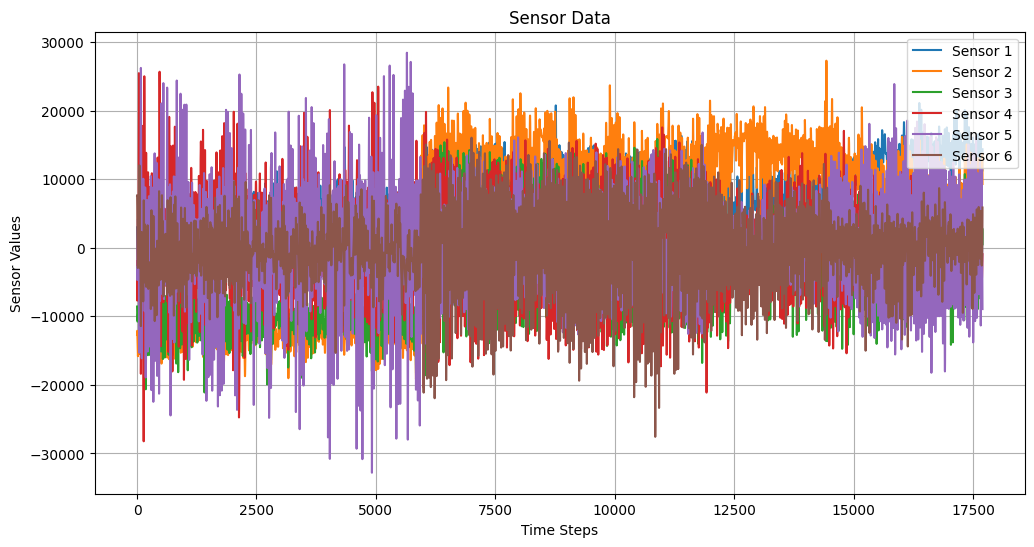

In [89]:
data = Bicep_Curl_data2
print(Bicep_Curl_data2.shape)
dims = data.shape[-1]  # 感測器數量
data_per_sensor = data.reshape(-1, dims) 
plot_2d_data(data_per_sensor)

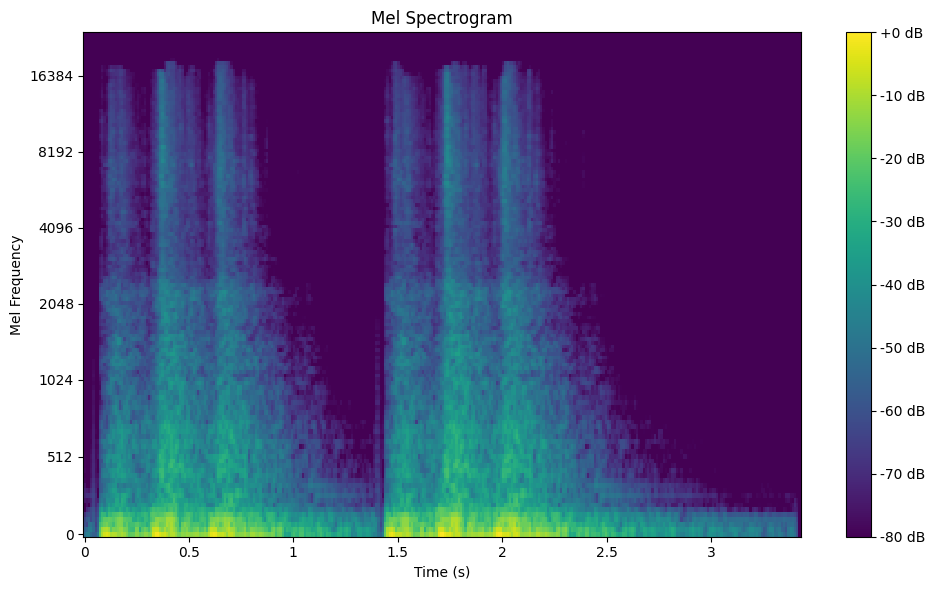

In [15]:
from pydub import AudioSegment
import librosa
import librosa.display
import matplotlib.pyplot as plt


# 讀取音訊檔案
file_path = 'record.mp3'  # 替換為實際檔案路徑
y, sr = librosa.load(file_path, sr=None)  # sr=None 保留原始採樣率

# 計算梅爾頻譜
n_fft = 2048  # FFT 長度
hop_length = 512  # 每幀的移動步長
n_mels = 128  # 梅爾頻帶數量

mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# 將梅爾頻譜轉為分貝尺度（更易視覺化）
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# 視覺化梅爾頻譜
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()


In [7]:
ffmpeg -i record.m4a record.wav


SyntaxError: invalid syntax (2487857558.py, line 1)

In [8]:
# 分割每組數據
bicep_train, bicep_test, bicep_y_train, bicep_y_test = train_test_split(
    Bicep_Curl_data2, 
    np.zeros(Bicep_Curl_data2.shape[0]),  # 標籤為 0
    test_size=0.2, 
    random_state=42
)

lateral_train, lateral_test, lateral_y_train, lateral_y_test = train_test_split(
    Lateral_Raise_data2, 
    np.ones(Lateral_Raise_data2.shape[0]),  # 標籤為 1
    test_size=0.54, 
    random_state=42
)

# 合併訓練集和測試集
X_train2 = np.vstack((bicep_train, lateral_train))
X_test2 = np.vstack((bicep_test, lateral_test))
y_train2 = np.hstack((bicep_y_train, lateral_y_train))
y_test2 = np.hstack((bicep_y_test, lateral_y_test))

# 提取 AG 和 IQ 數據
AG_train2, IQ_train2 = X_train2[:, :, :6], X_train2[:, :, 6:]
AG_test2, IQ_test2 = X_test2[:, :, :6], X_test2[:, :, 6:]

# 確認輸出形狀
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((428, 8, 8), (179, 8, 8), (428,), (179,))

## 模型建構

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.ticker import MaxNLocator

def plot_confusion_matrix(y_true, y_pred, class_names):
    """繪製混淆矩陣"""
    cm = confusion_matrix(y_true, y_pred) 
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

def plot_metric(history, metric, title, ylabel, ylim=False):
    """繪製訓練與驗證曲線的通用函數"""
    plt.plot(range(1, len(history.history[metric]) + 1), history.history[metric], label=f'Train {metric.capitalize()}')
    val_metric = f'val_{metric}'
    if val_metric in history.history:
        plt.plot(range(1, len(history.history[val_metric]) + 1), history.history[val_metric], label=f'Validation {metric.capitalize()}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    if ylim:
        plt.ylim(0, 1)  # 固定 y 軸範圍為 0 到 1
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # X軸整數刻度
    plt.legend()

def print_result(y_test, y_pred, history, class_names):
    # 输出分类报告
    # print("\nClassification Report:")
    # print(classification_report(y_test, y_pred))

    # 輸出混淆矩陣
    plot_confusion_matrix(y_test, y_pred, class_names)

    # 繪製訓練曲線
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_metric(history, 'loss', 'Loss Over Epochs', 'Loss')  # 損失曲線
    plt.subplot(1, 2, 2)
    plot_metric(history, 'accuracy', 'Accuracy Over Epochs', 'Accuracy', True)  # 準確率曲線
    plt.tight_layout()
    plt.show()

### keras版模型建構

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense, GlobalAveragePooling1D

def model_fit(model_type, X_train, X_test, y_train, y_test, result=False, class_names=['Bicep Curl','Lateral Raise']):
  def build_nn_model():
    return Sequential([
      Input(shape=(X_train.shape[1],)), 
      Dense(64, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(1, activation='sigmoid')
    ])

  def build_rnn_model():
    return Sequential([
      Input(shape=(X_train.shape[1], X_train.shape[2])),
      LSTM(64, return_sequences=False),
      Dense(16, activation='relu'),
      Dense(1, activation='sigmoid')
    ])
  
  def build_1dcnn_model():
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),  
        Conv1D(filters=64, kernel_size=3, activation='relu'),  
        GlobalAveragePooling1D(),  
        Dense(16, activation='relu'),  
        Dense(1, activation='sigmoid')  
    ])
    
    return model
  
  model = build_rnn_model() if model_type == 'RNN' else build_1dcnn_model() if model_type == '1dCNN' else build_nn_model()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # 訓練神經網路並保存歷史數據
  history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_test, y_test))

  # 評估模型
  if result:
    # 評估模型在測試集上的表現
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # 預測
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 二分類閾值設定為 0.5

    print_result(y_test, y_pred, history, class_names)

  return model.evaluate(X_test, y_test, verbose=0)  #loss, accuracy

# def test_model(X_train, X_test, y_train, y_test):
#   Accuracy = []
#   for _ in range(10):
#       loss, accuracy = model_fit(X_train, X_test, y_train, y_test)
#       Accuracy.append(accuracy)
#       print(f"Test Accuracy: {accuracy:.2f}")

#   print(f'avg Accuracy {sum(Accuracy)/len(Accuracy)}')


### pytorch版 模型建構

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.ticker import MaxNLocator


# 繪製訓練曲線
# def torch_plot_metric(history, metric, title, ylabel):
#     plt.plot(history[metric], label=f'Train {metric.capitalize()}')
#     plt.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
#     plt.title(title)
#     plt.xlabel('Epochs')
#     plt.ylabel(ylabel)
#     plt.ylim(0, 1)
#     plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#     plt.legend()


# 與keras相同的history對象
class History:
    def __init__(self):
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }

    def update(self, loss, accuracy, val_loss, val_accuracy):
        self.history['loss'].append(loss)
        self.history['accuracy'].append(accuracy)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

    def __getitem__(self, key):
        if isinstance(key, int):
            # 透過索引傳回一個包含所有指標的字典
            return {metric: self.history[metric][key] for metric in self.history}
        elif key in self.history:
            # 透過鍵返回特定指標的列表
            return self.history[key]
        else:
            raise KeyError(f"Invalid key: {key}")

def torch_model_fit(model_type, X_train, X_test, y_train, y_test, result=False, class_names=['Bicep Curl', 'Lateral Raise']):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_size = X_train.shape[2] if model_type == 'RNN' else X_train.shape[1]
    
    # 定义模型
    class NNModel(nn.Module):
        def __init__(self, input_size):
            super(NNModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            return self.model(x)

    class RNNModel(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(RNNModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, 16),
                nn.ReLU(),
                nn.Linear(16, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            _, (h_n, _) = self.lstm(x)
            return self.fc(h_n[-1])
    
    # 选择模型
    if model_type == 'RNN':
        model = RNNModel(input_size=X_train.shape[2], hidden_size=64).to(device)
    else:
        model = NNModel(input_size=X_train.shape[1]).to(device)

    # 数据加载
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                   torch.tensor(y_train, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                  torch.tensor(y_test, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 定义损失函数和优化器
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练过程
    history = History()
    for epoch in range(20):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += ((y_pred > 0.5).int() == y_batch.int()).sum().item()
            total += y_batch.size(0)

        train_accuracy = correct / total

        # 验证过程
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
                correct += ((y_pred > 0.5).int() == y_batch.int()).sum().item()
                total += y_batch.size(0)

        val_accuracy = correct / total

        # 更新历史记录
        history.update(train_loss / len(train_loader), train_accuracy, val_loss / len(test_loader), val_accuracy)

    # 评估模型
    if result:
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                preds = model(X_batch)
                y_true.extend(y_batch.numpy())
                y_pred.extend((preds.cpu().numpy() > 0.5).astype("int32").flatten())

        print_result(y_test, y_pred, history, class_names)

    return history['val_loss'][-1], history['val_accuracy'][-1]


## 前期融合數據測試

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9872 - loss: 6.9108   
Test Loss: 18.0933
Test Accuracy: 0.9777
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


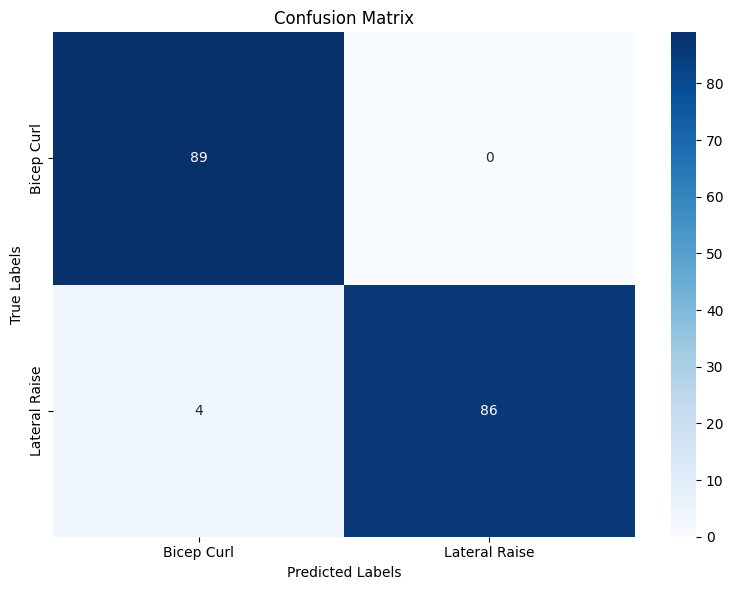

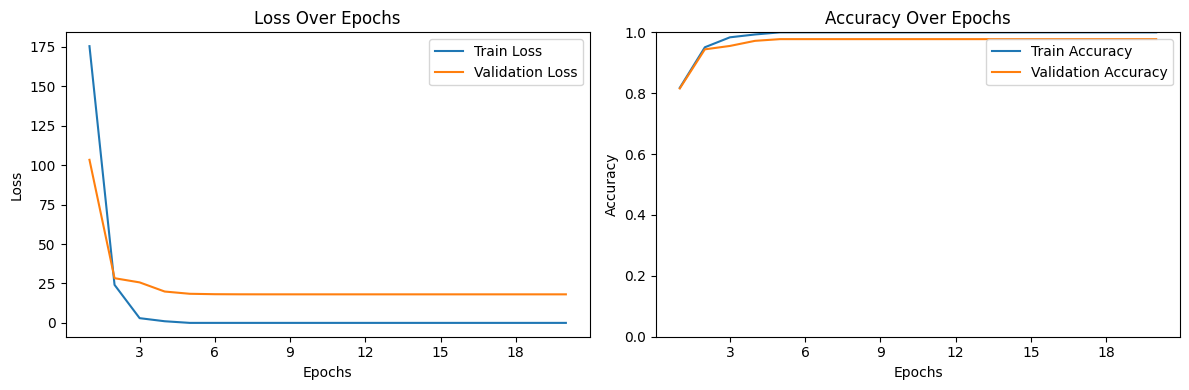

final acc 0.9776536226272583


In [9]:
_, accuracy = model_fit('1dCNN', AG_train, AG_test, y_train, y_test, True)
# _, accuracy = torch_model_fit('RNN', AG_train, AG_test, y_train, y_test, True)
print(f'final acc {accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7900 - loss: 8.8418
Test Loss: 17.6114
Test Accuracy: 0.6313
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


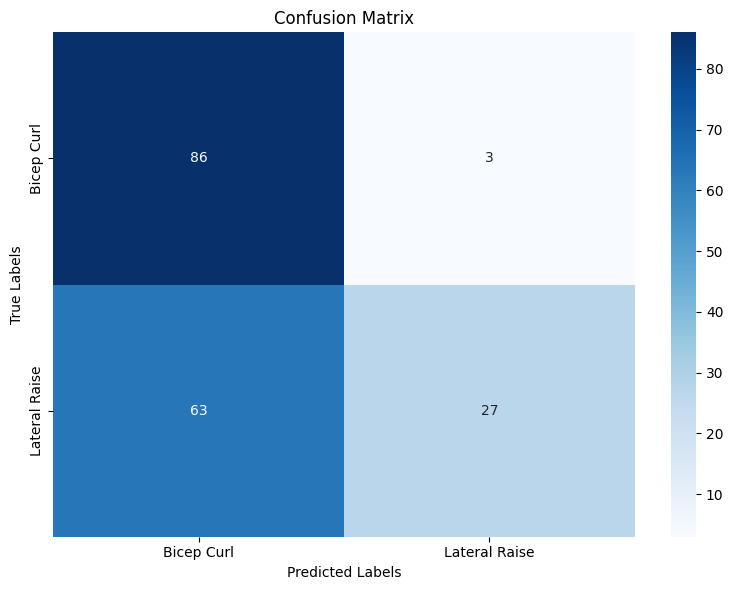

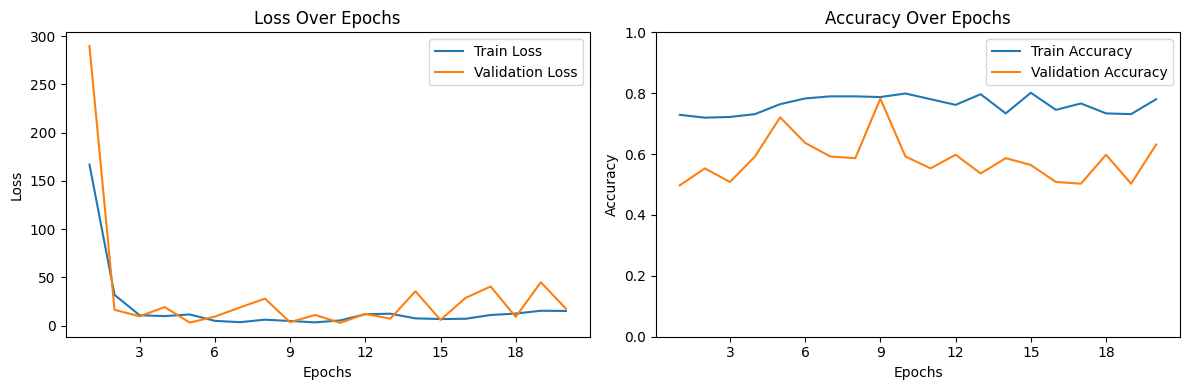

final acc 0.6312848925590515


In [10]:
_, accuracy = model_fit('1dCNN', IQ_train, IQ_test, y_train, y_test, True)
# _, accuracy = torch_model_fit('RNN', IQ_train, IQ_test, y_train, y_test, True)
print(f'final acc {accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.9863 - loss: 6.7791   
Test Loss: 9.1641
Test Accuracy: 0.9777
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


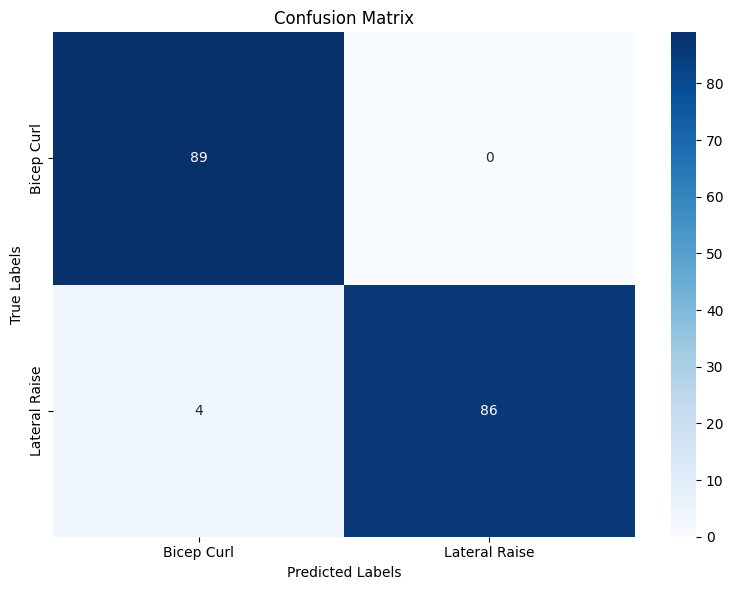

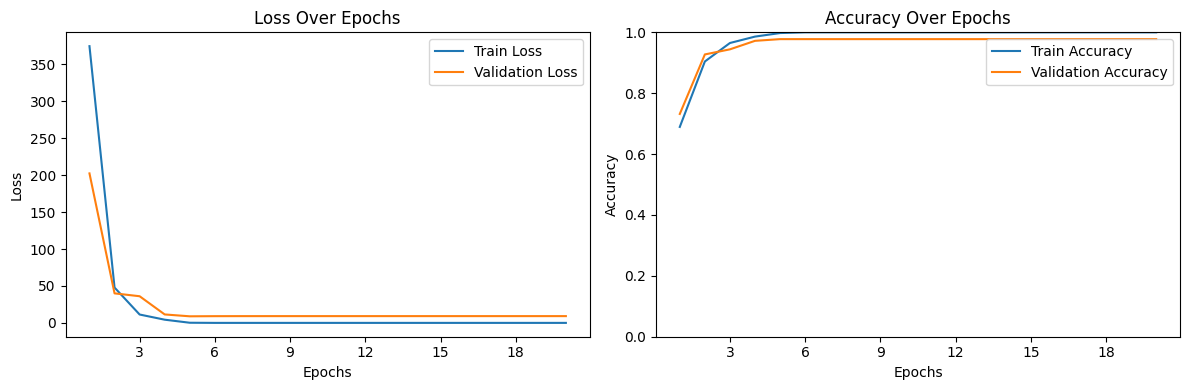

final acc 0.9776536226272583


In [11]:
_, accuracy = model_fit('1dCNN', X_train, X_test, y_train, y_test, True)
# _, accuracy = torch_model_fit('RNN', X_train, X_test, y_train, y_test, True)

print(f'final acc {accuracy}')

## PSO

In [12]:
import numpy as np
from pyswarms.single import GlobalBestPSO
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import plot_cost_history

def Convergence_Curve(cost_history):
    """PSO 收斂曲線"""
    plt.figure(figsize=(8, 6))
    plot_cost_history(cost_history=cost_history)
    plt.title("Convergence Curve", fontsize=16)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Cost", fontsize=14)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # X軸整數刻度
    plt.grid(True)
    plt.show()

# 目標函數
def objective_function(weights):
    # 这里 weights 是一个 (num_particles, 8) 的矩阵
    results = []
    for w in weights:
        weighted_train_data = X_train * w  # train_data 为 (485, 4, 8)

        # _, accuracy = model_fit('RNN', weighted_train_data, X_test, y_train, y_test)
        _, accuracy = torch_model_fit('RNN', weighted_train_data, X_test, y_train, y_test)
        
        results.append( -accuracy )  # PSO 是寻优过程，目标是最小化误差
        
    return np.array(results)

# PSO 參數
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  
# 維度
dimensions = 8
# 粒子數量
n_particles = 20
# 迭代次數
iters = 30

# 設定權重範圍
bounds = (np.zeros(dimensions), np.array([0.1]*dimensions))

In [13]:
"""
# 目標函數
def objective_function(weights):
    # weights 是一個 (num_particles, 8) 的矩陣
    results = []
    for w in weights:
        weighted_train_data = X_train * w  # train_data 為 (N, 4, 8)

        _, accuracy = model_fit(weighted_train_data, X_test, y_train, y_test)
        
        results.append( -accuracy )  
        
    return np.array(results)

# PSO 參數
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  
# 維度
dimensions = 8
# 粒子數量
n_particles = 20
# 迭代次數
iters = 30

optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)
best_cost, best_pos = optimizer.optimize(objective_function, iters=iters)

# 使用最佳權重再次訓練模型
weighted_train_data = X_train * best_pos  # 應用最優權重
_, accuracy = torch_model_fit('RNN', weighted_train_data, X_test, y_train, y_test, True)
print(f'final acc {accuracy}')
"""


"\n# 目標函數\ndef objective_function(weights):\n    # weights 是一個 (num_particles, 8) 的矩陣\n    results = []\n    for w in weights:\n        weighted_train_data = X_train * w  # train_data 為 (N, 4, 8)\n\n        _, accuracy = model_fit(weighted_train_data, X_test, y_train, y_test)\n        \n        results.append( -accuracy )  \n        \n    return np.array(results)\n\n# PSO 參數\noptions = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  \n# 維度\ndimensions = 8\n# 粒子數量\nn_particles = 20\n# 迭代次數\niters = 30\n\noptimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options)\nbest_cost, best_pos = optimizer.optimize(objective_function, iters=iters)\n\n# 使用最佳權重再次訓練模型\nweighted_train_data = X_train * best_pos  # 應用最優權重\n_, accuracy = torch_model_fit('RNN', weighted_train_data, X_test, y_train, y_test, True)\nprint(f'final acc {accuracy}')\n"

In [14]:
# optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)
# best_cost, best_pos = optimizer.optimize(objective_function, iters=iters)
# Convergence_Curve(optimizer.cost_history)

In [15]:
# # 使用最佳權重再次訓練模型
# weighted_train_data = X_train * best_pos  # 應用最優權重
# _, accuracy = torch_model_fit('RNN', weighted_train_data, X_test, y_train, y_test, True)
# print(f'final acc {accuracy}')

## 中期融合

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.9908 - loss: 2.6155   
Test Loss: 4.4779
Test Accuracy: 0.9832


2024-11-25 10:23:31,830 - tensorflow - WARNING - 5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025288D820C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


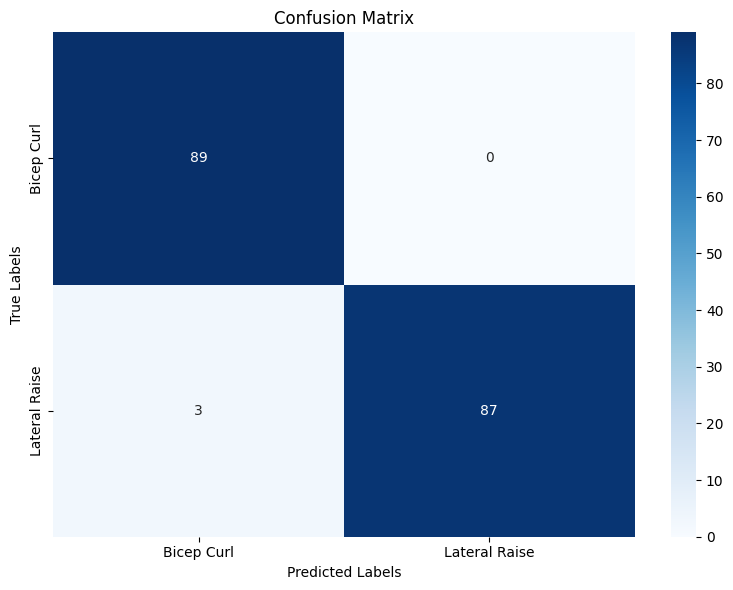

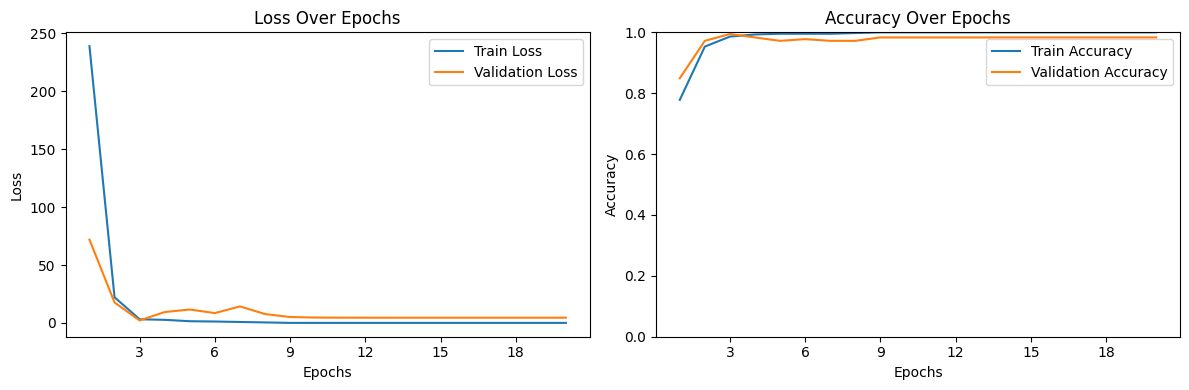

final acc 0.9832402467727661


In [16]:
_, accuracy = model_fit('1dCNN', AG_train2, AG_test2, y_train2, y_test2, True)
# _, accuracy = torch_model_fit('RNN', AG_train, AG_test, y_train, y_test, True)
print(f'final acc {accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.7390 - loss: 0.6419
Test Loss: 0.7111
Test Accuracy: 0.4972
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


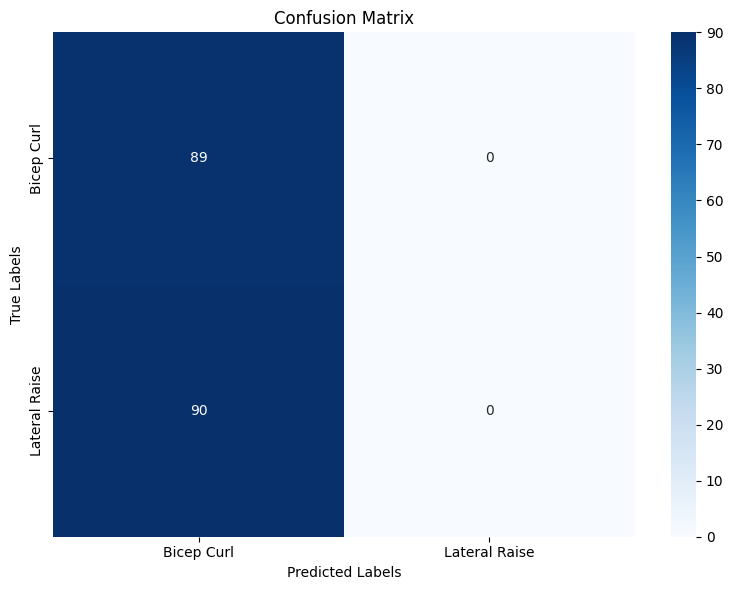

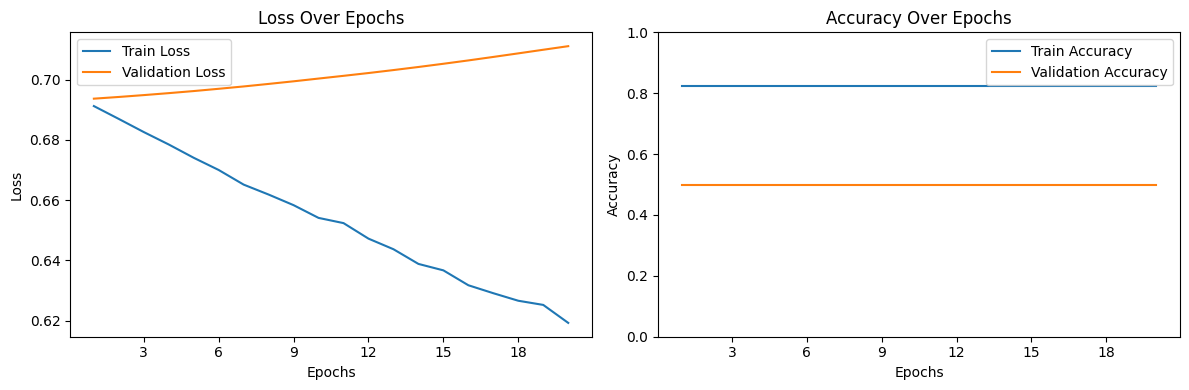

final acc 0.4972067177295685


In [17]:
_, accuracy = model_fit('1dCNN', IQ_train2, IQ_test2, y_train2, y_test2, True)
# _, accuracy = torch_model_fit('RNN', IQ_train, IQ_test, y_train, y_test, True)
print(f'final acc {accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9897 - loss: 5.5932   
Test Loss: 8.7649
Test Accuracy: 0.9832
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


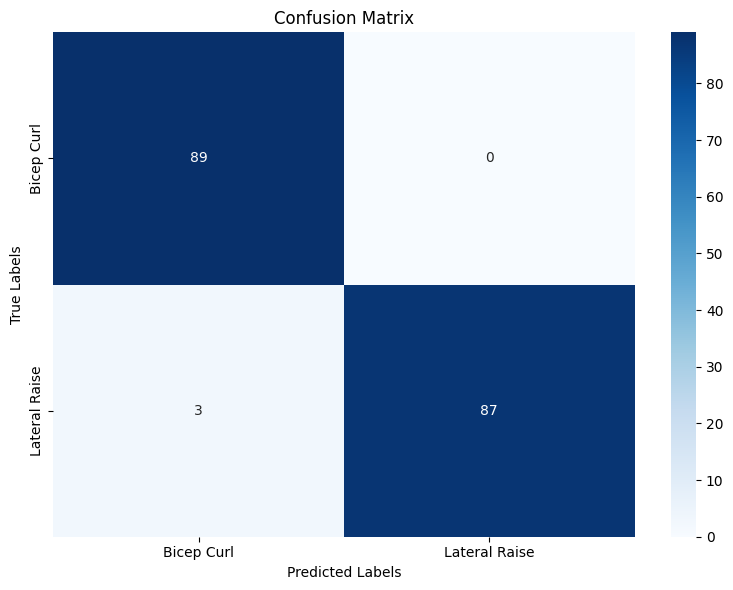

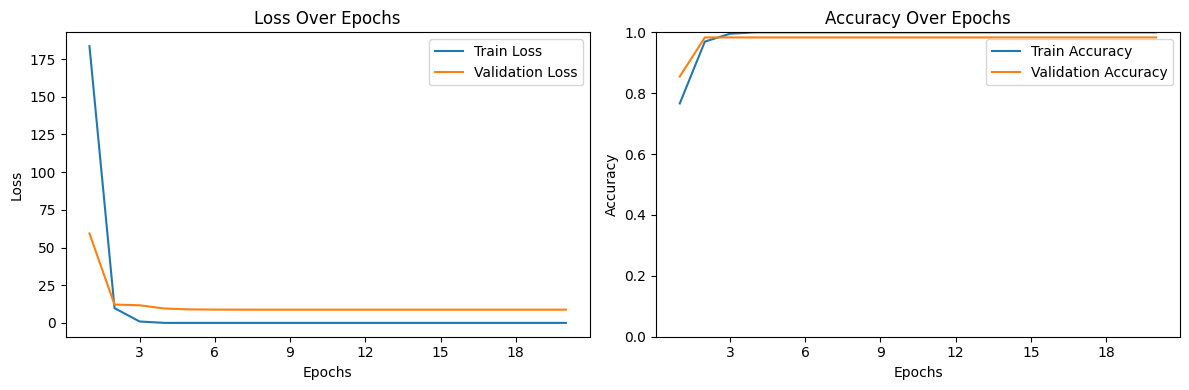

final acc 0.9832402467727661


In [18]:
_, accuracy = model_fit('1dCNN', X_train2, X_test2, y_train2, y_test2, True)
# _, accuracy = torch_model_fit('RNN', X_train, X_test, y_train, y_test, True)

print(f'final acc {accuracy}')

## 全部拆開

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv1D
from keras.models import Model

def conv1d_result(X_train, i = 0, title=''):# 您可以更i來選擇不同的樣本
# 繪製原始輸入數據
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(X_train[0, :, 0], marker='o', linestyle='-', color='b')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

    plt.title(f'{title} raw data')
    plt.xlabel('timestep')
    plt.ylabel('value')

    # 構建 Conv1D 模型
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    conv_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    model = Model(inputs=input_layer, outputs=conv_layer)

    # 執行卷積運算
    conv_output = model.predict(X_train)
    
    num_filters = conv_output.shape[-1]

    # 繪製第 i 個樣本的所有特徵圖
    plt.figure(figsize=(20, 20))
    for filter_index in range(num_filters):
        plt.subplot(8, 4, filter_index + 1)  # 將 32 個特徵圖繪製成 8x4 的圖表
        plt.plot(conv_output[i, :, filter_index], marker='o', linestyle='-', color='b')
        plt.title(f'{title} after conv1d {filter_index + 1}')
        plt.xlabel('timestep')
        plt.ylabel('value')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

    plt.tight_layout()
    plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


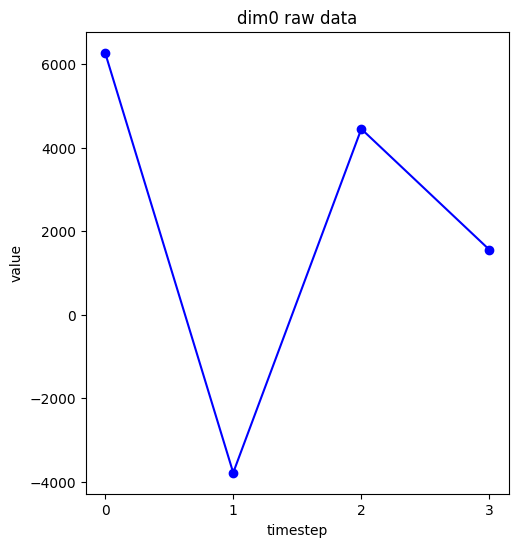

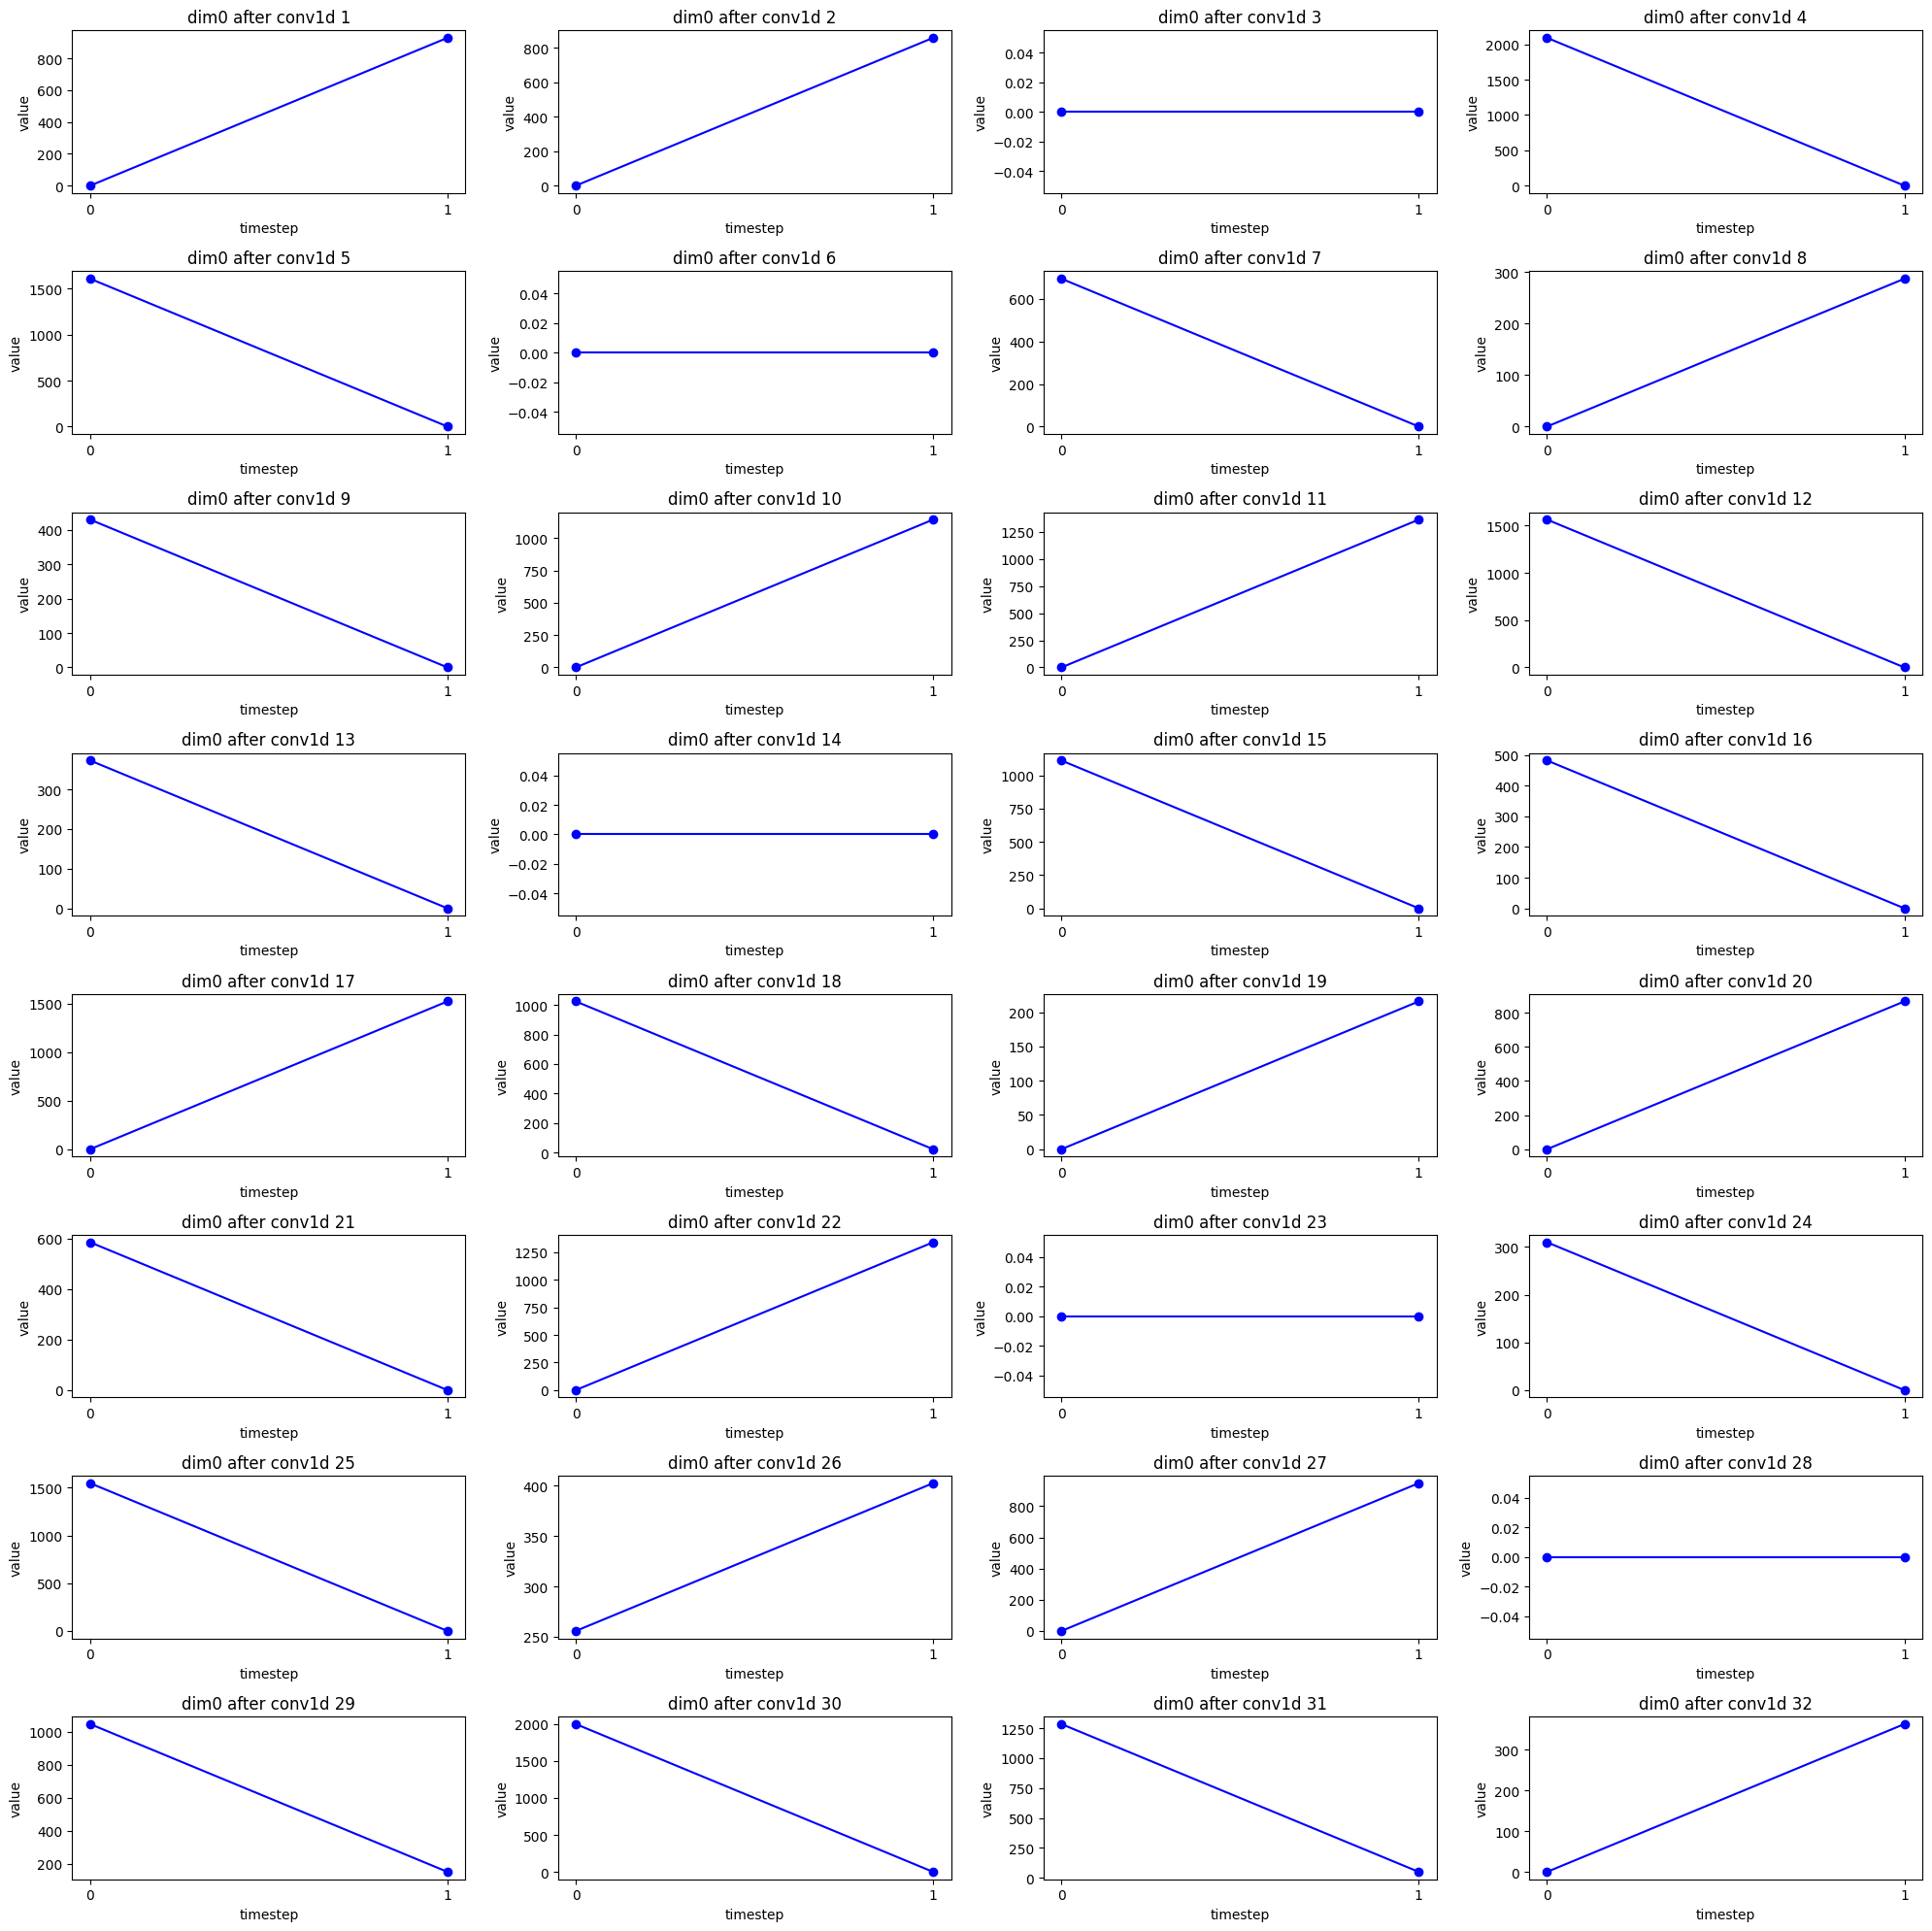

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


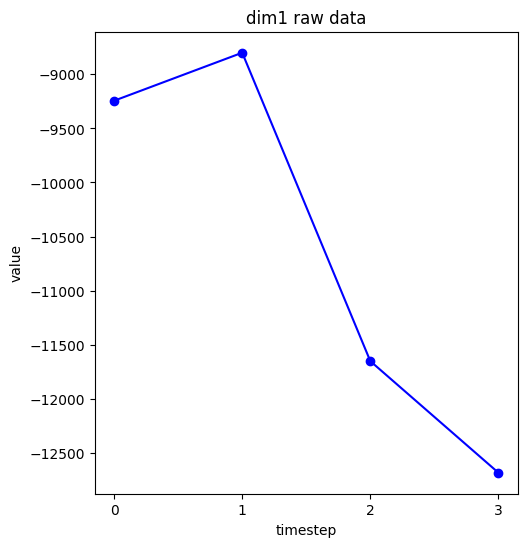

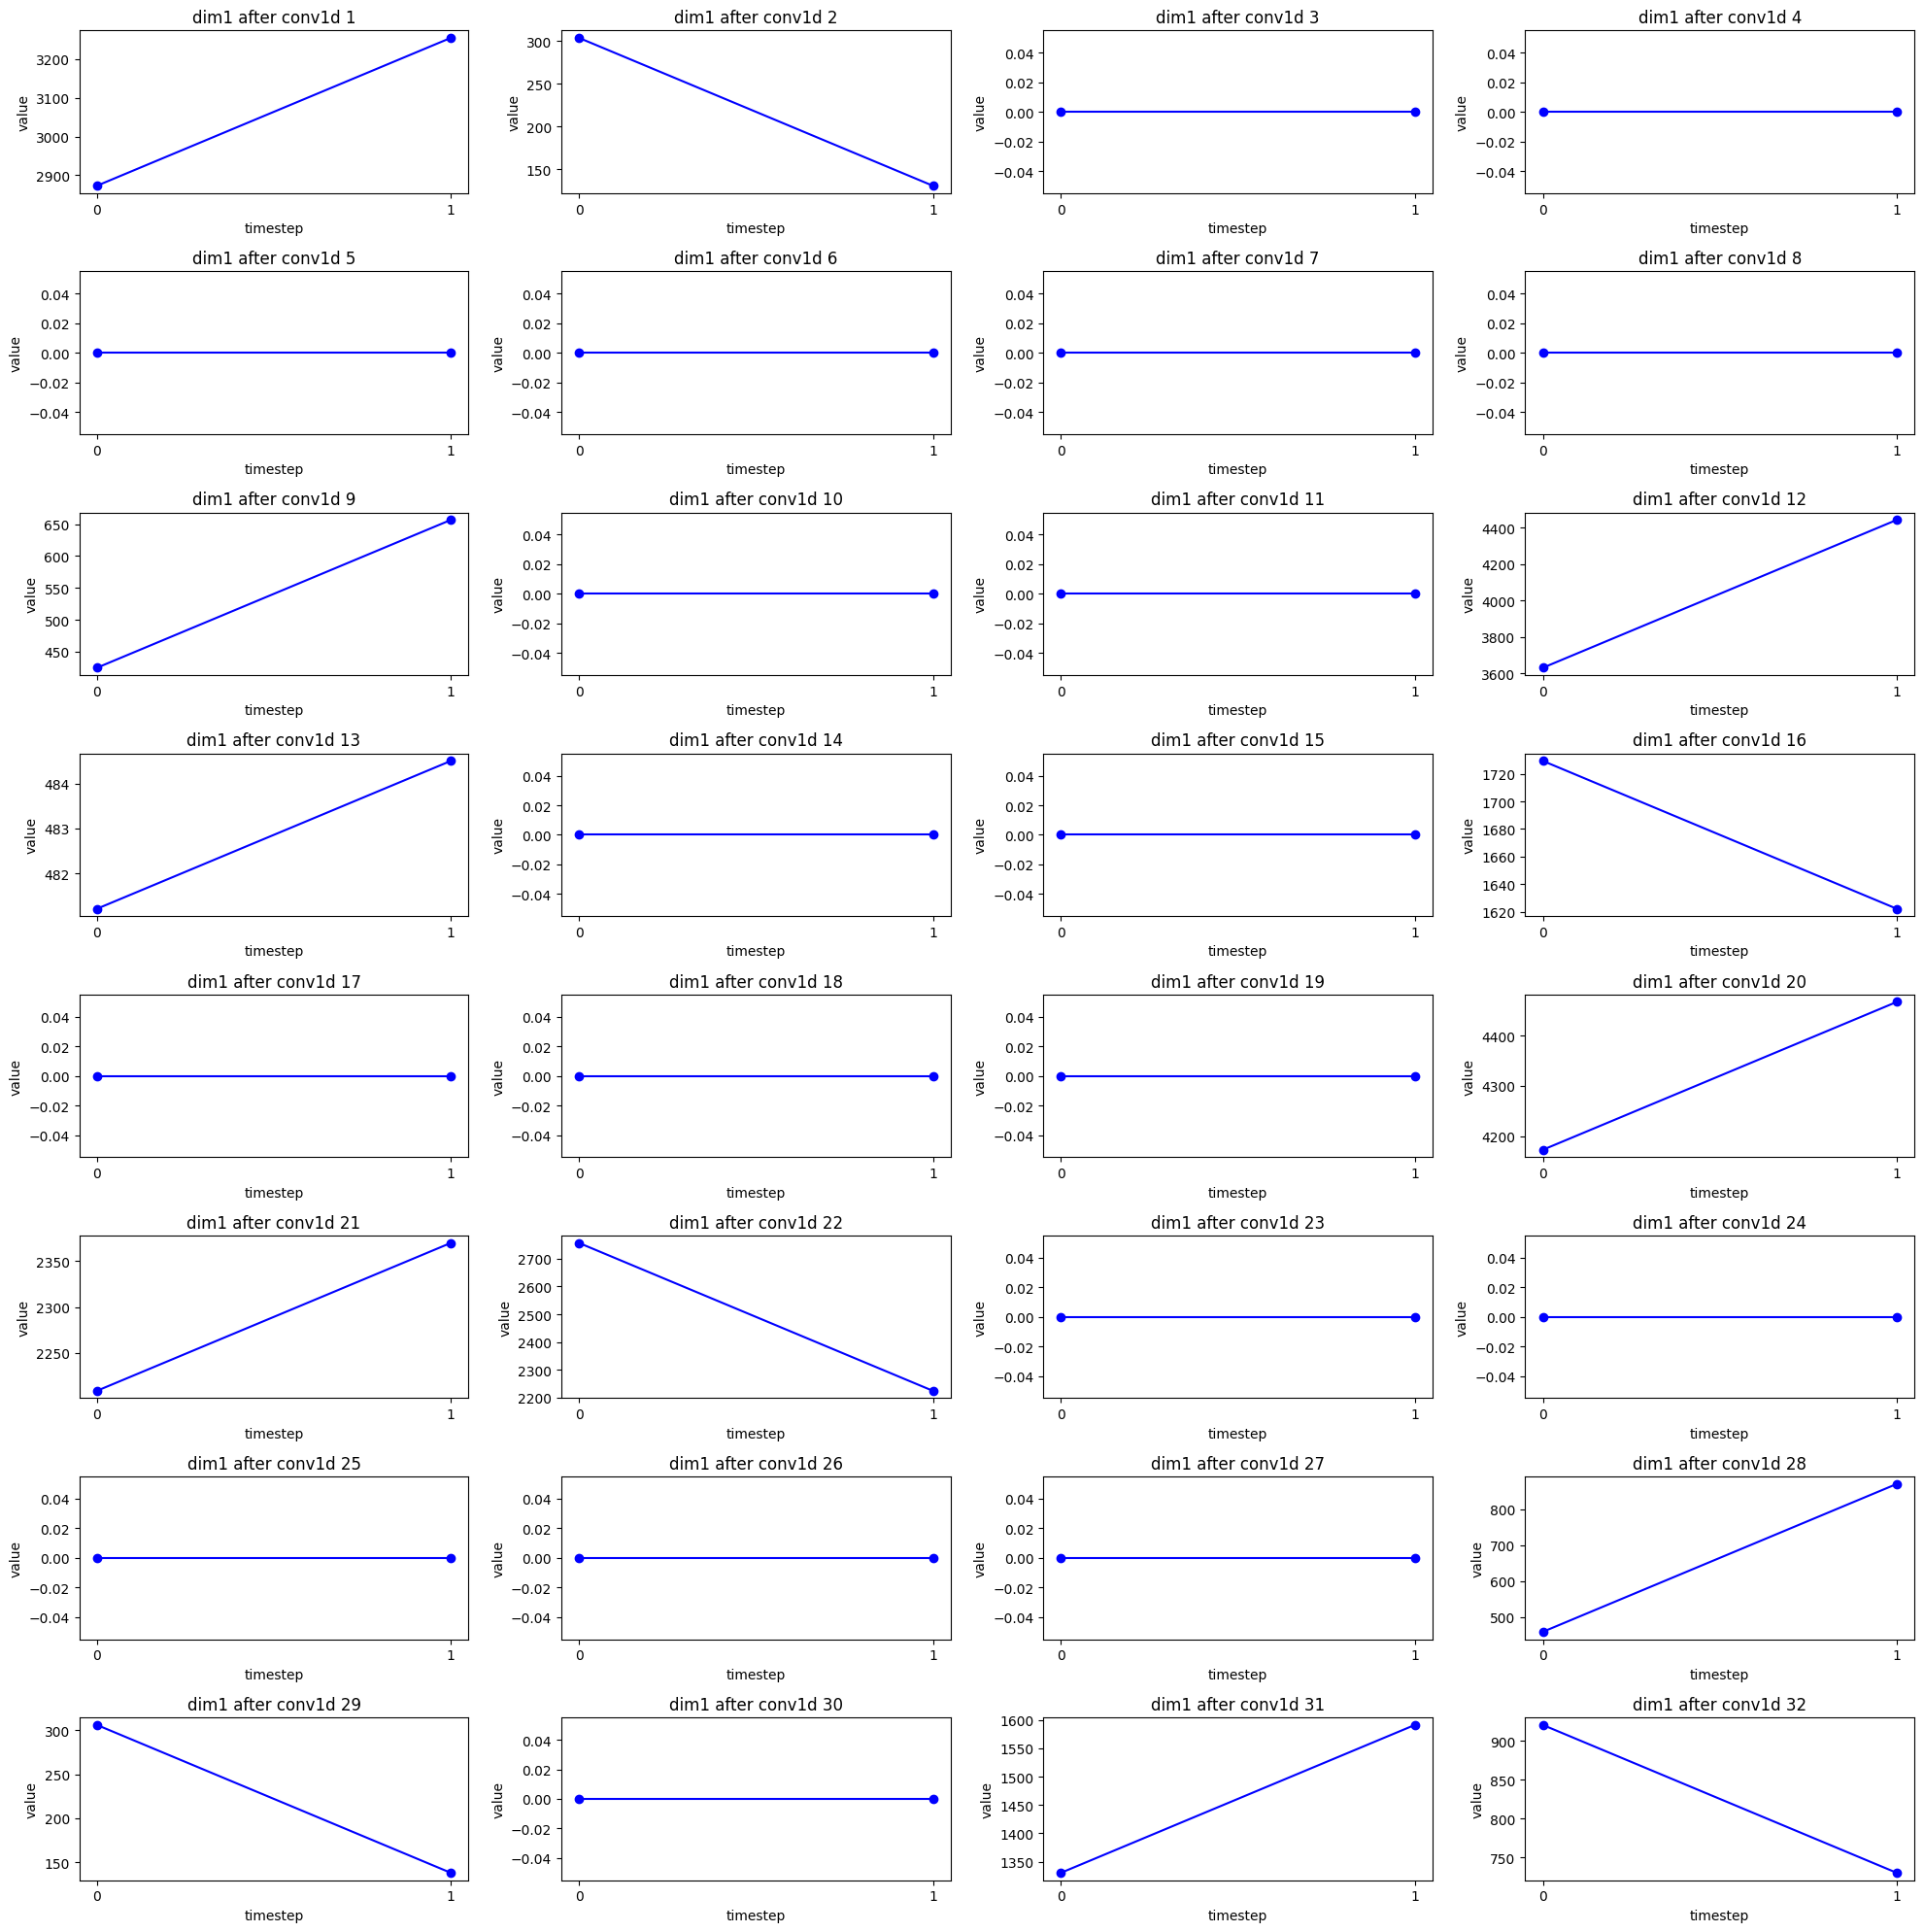

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


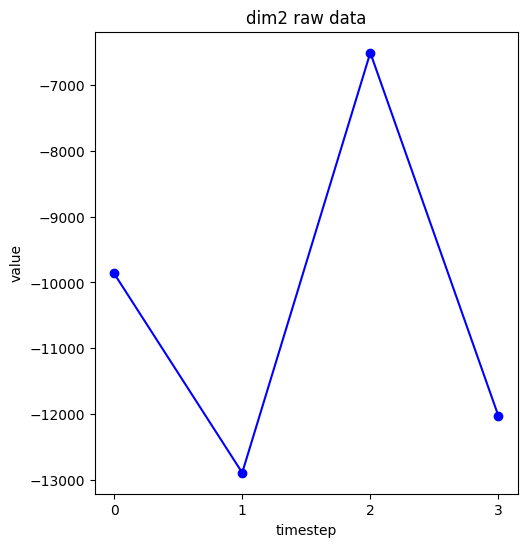

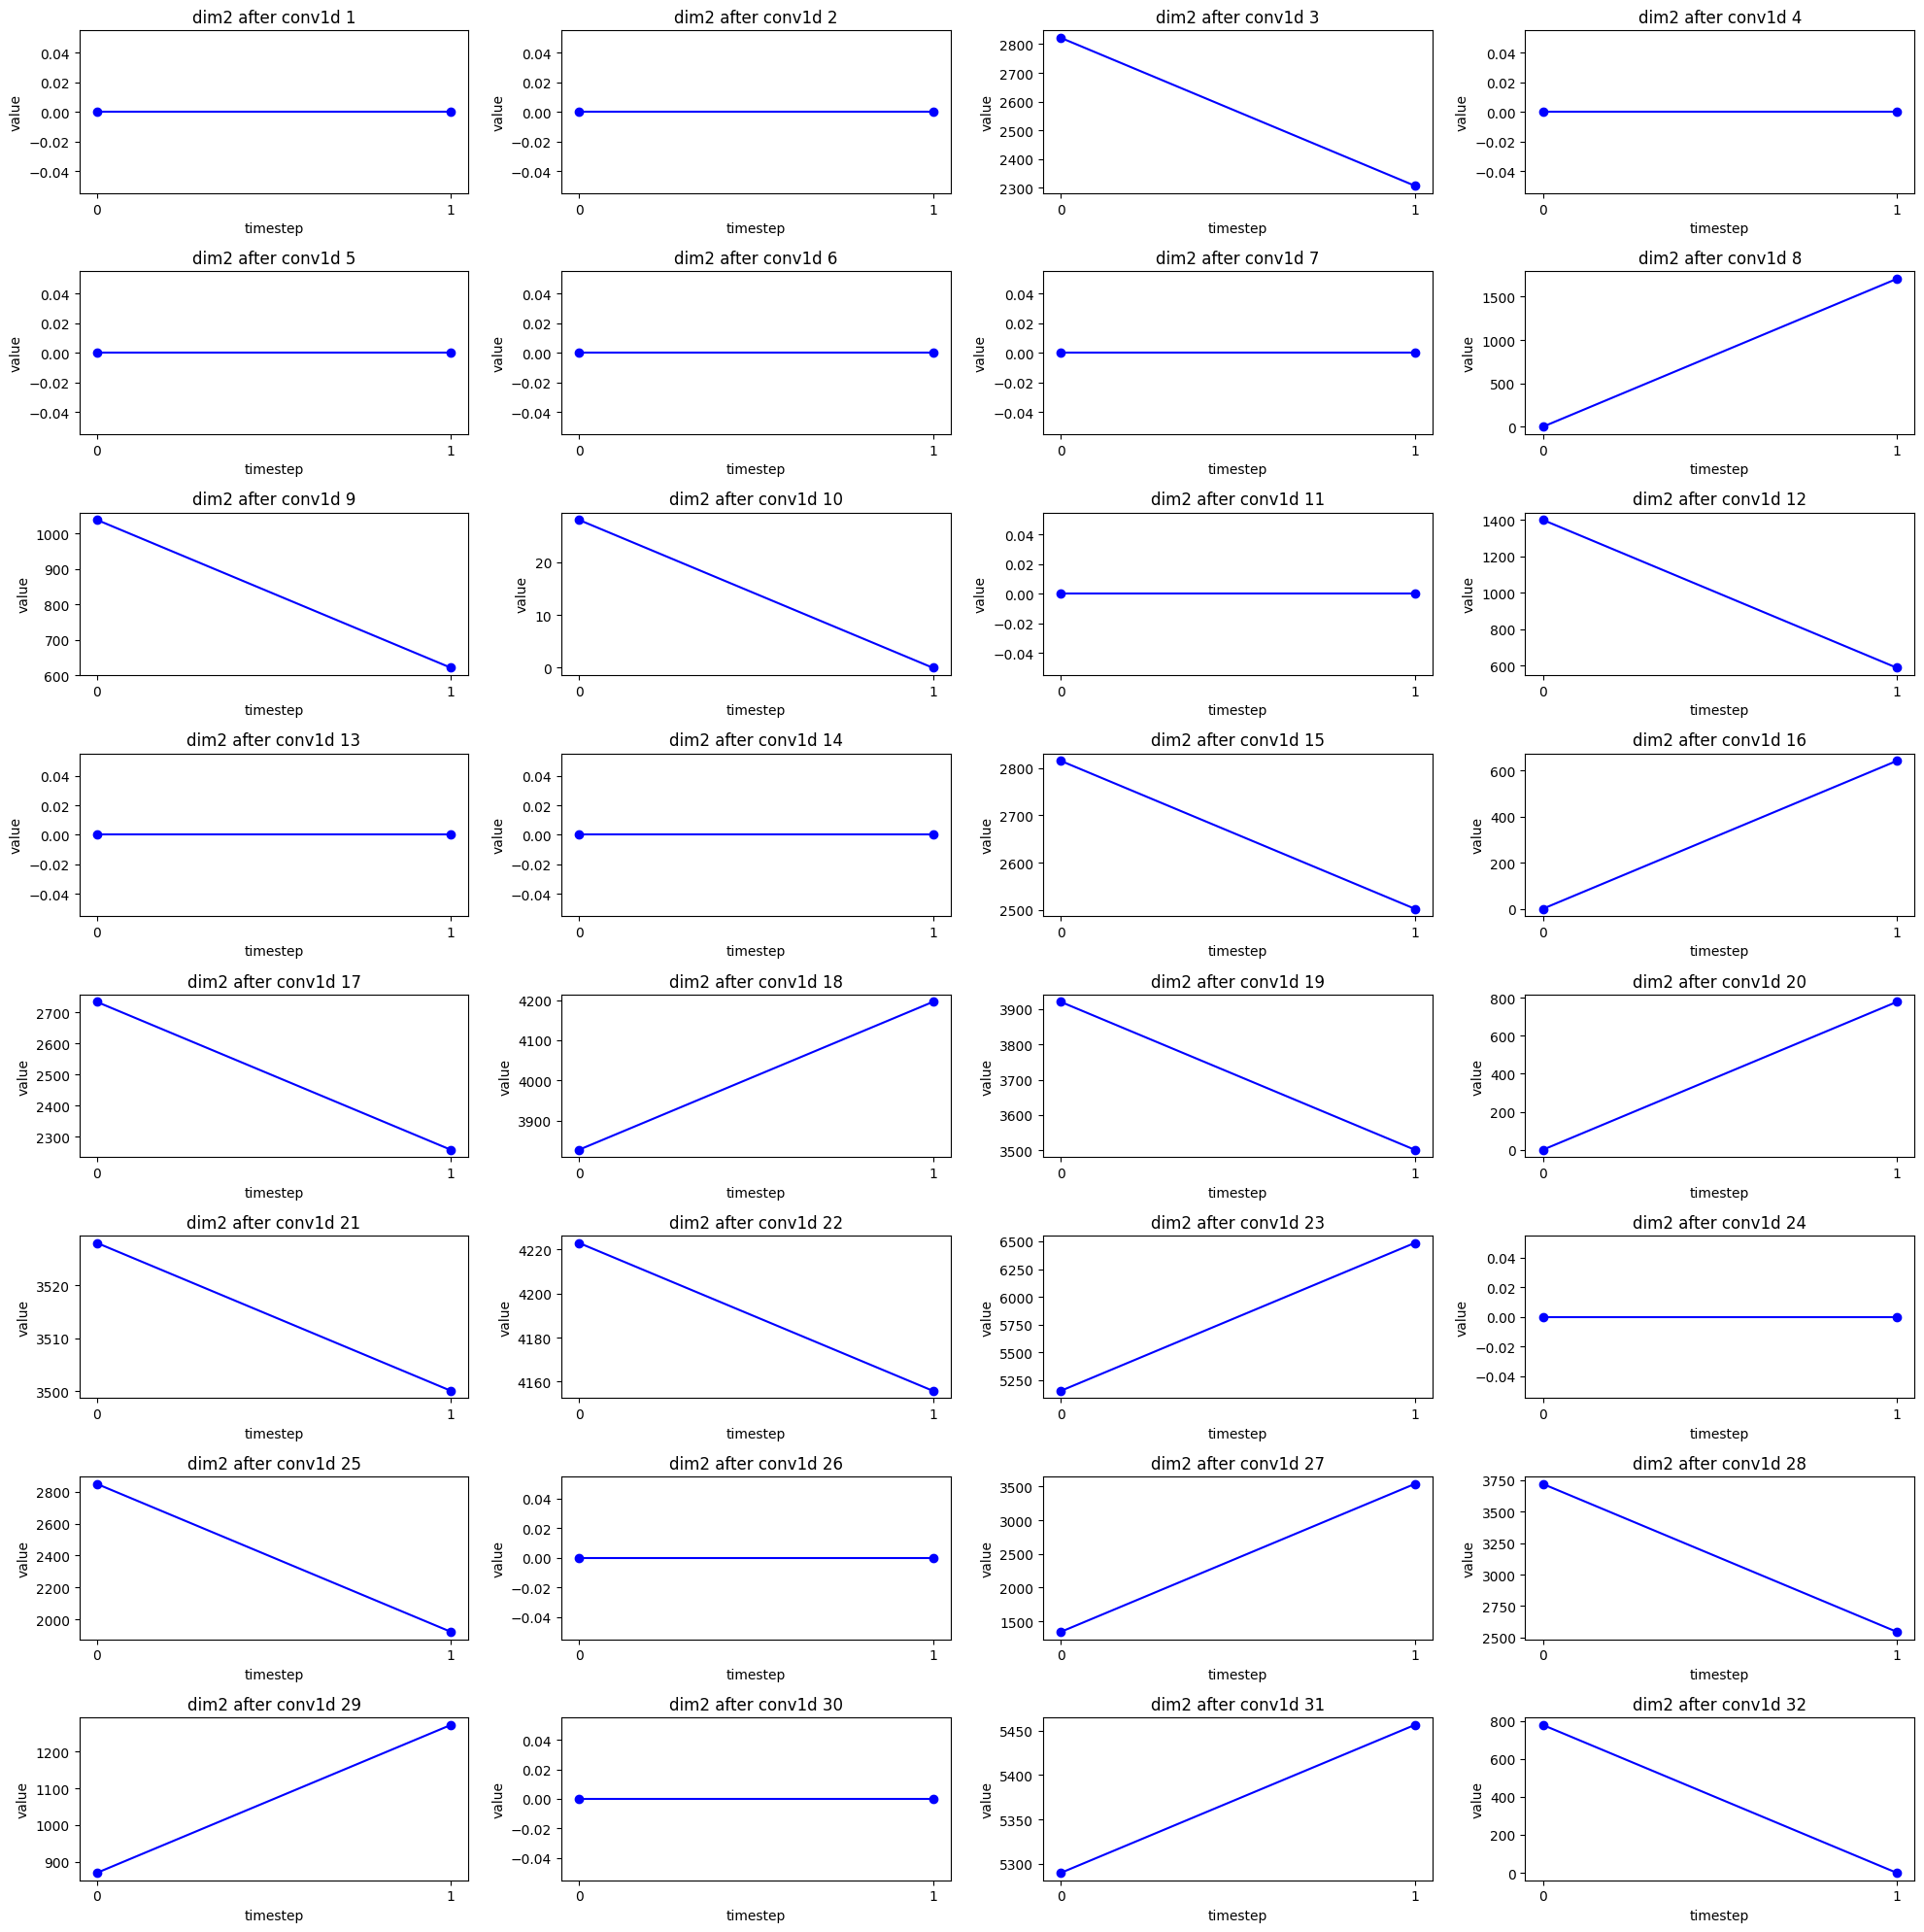

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


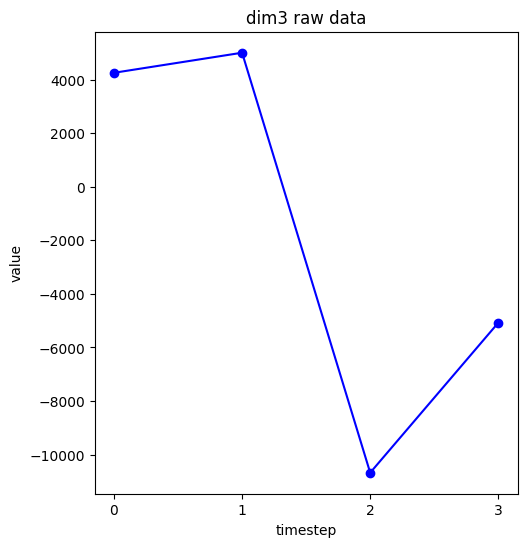

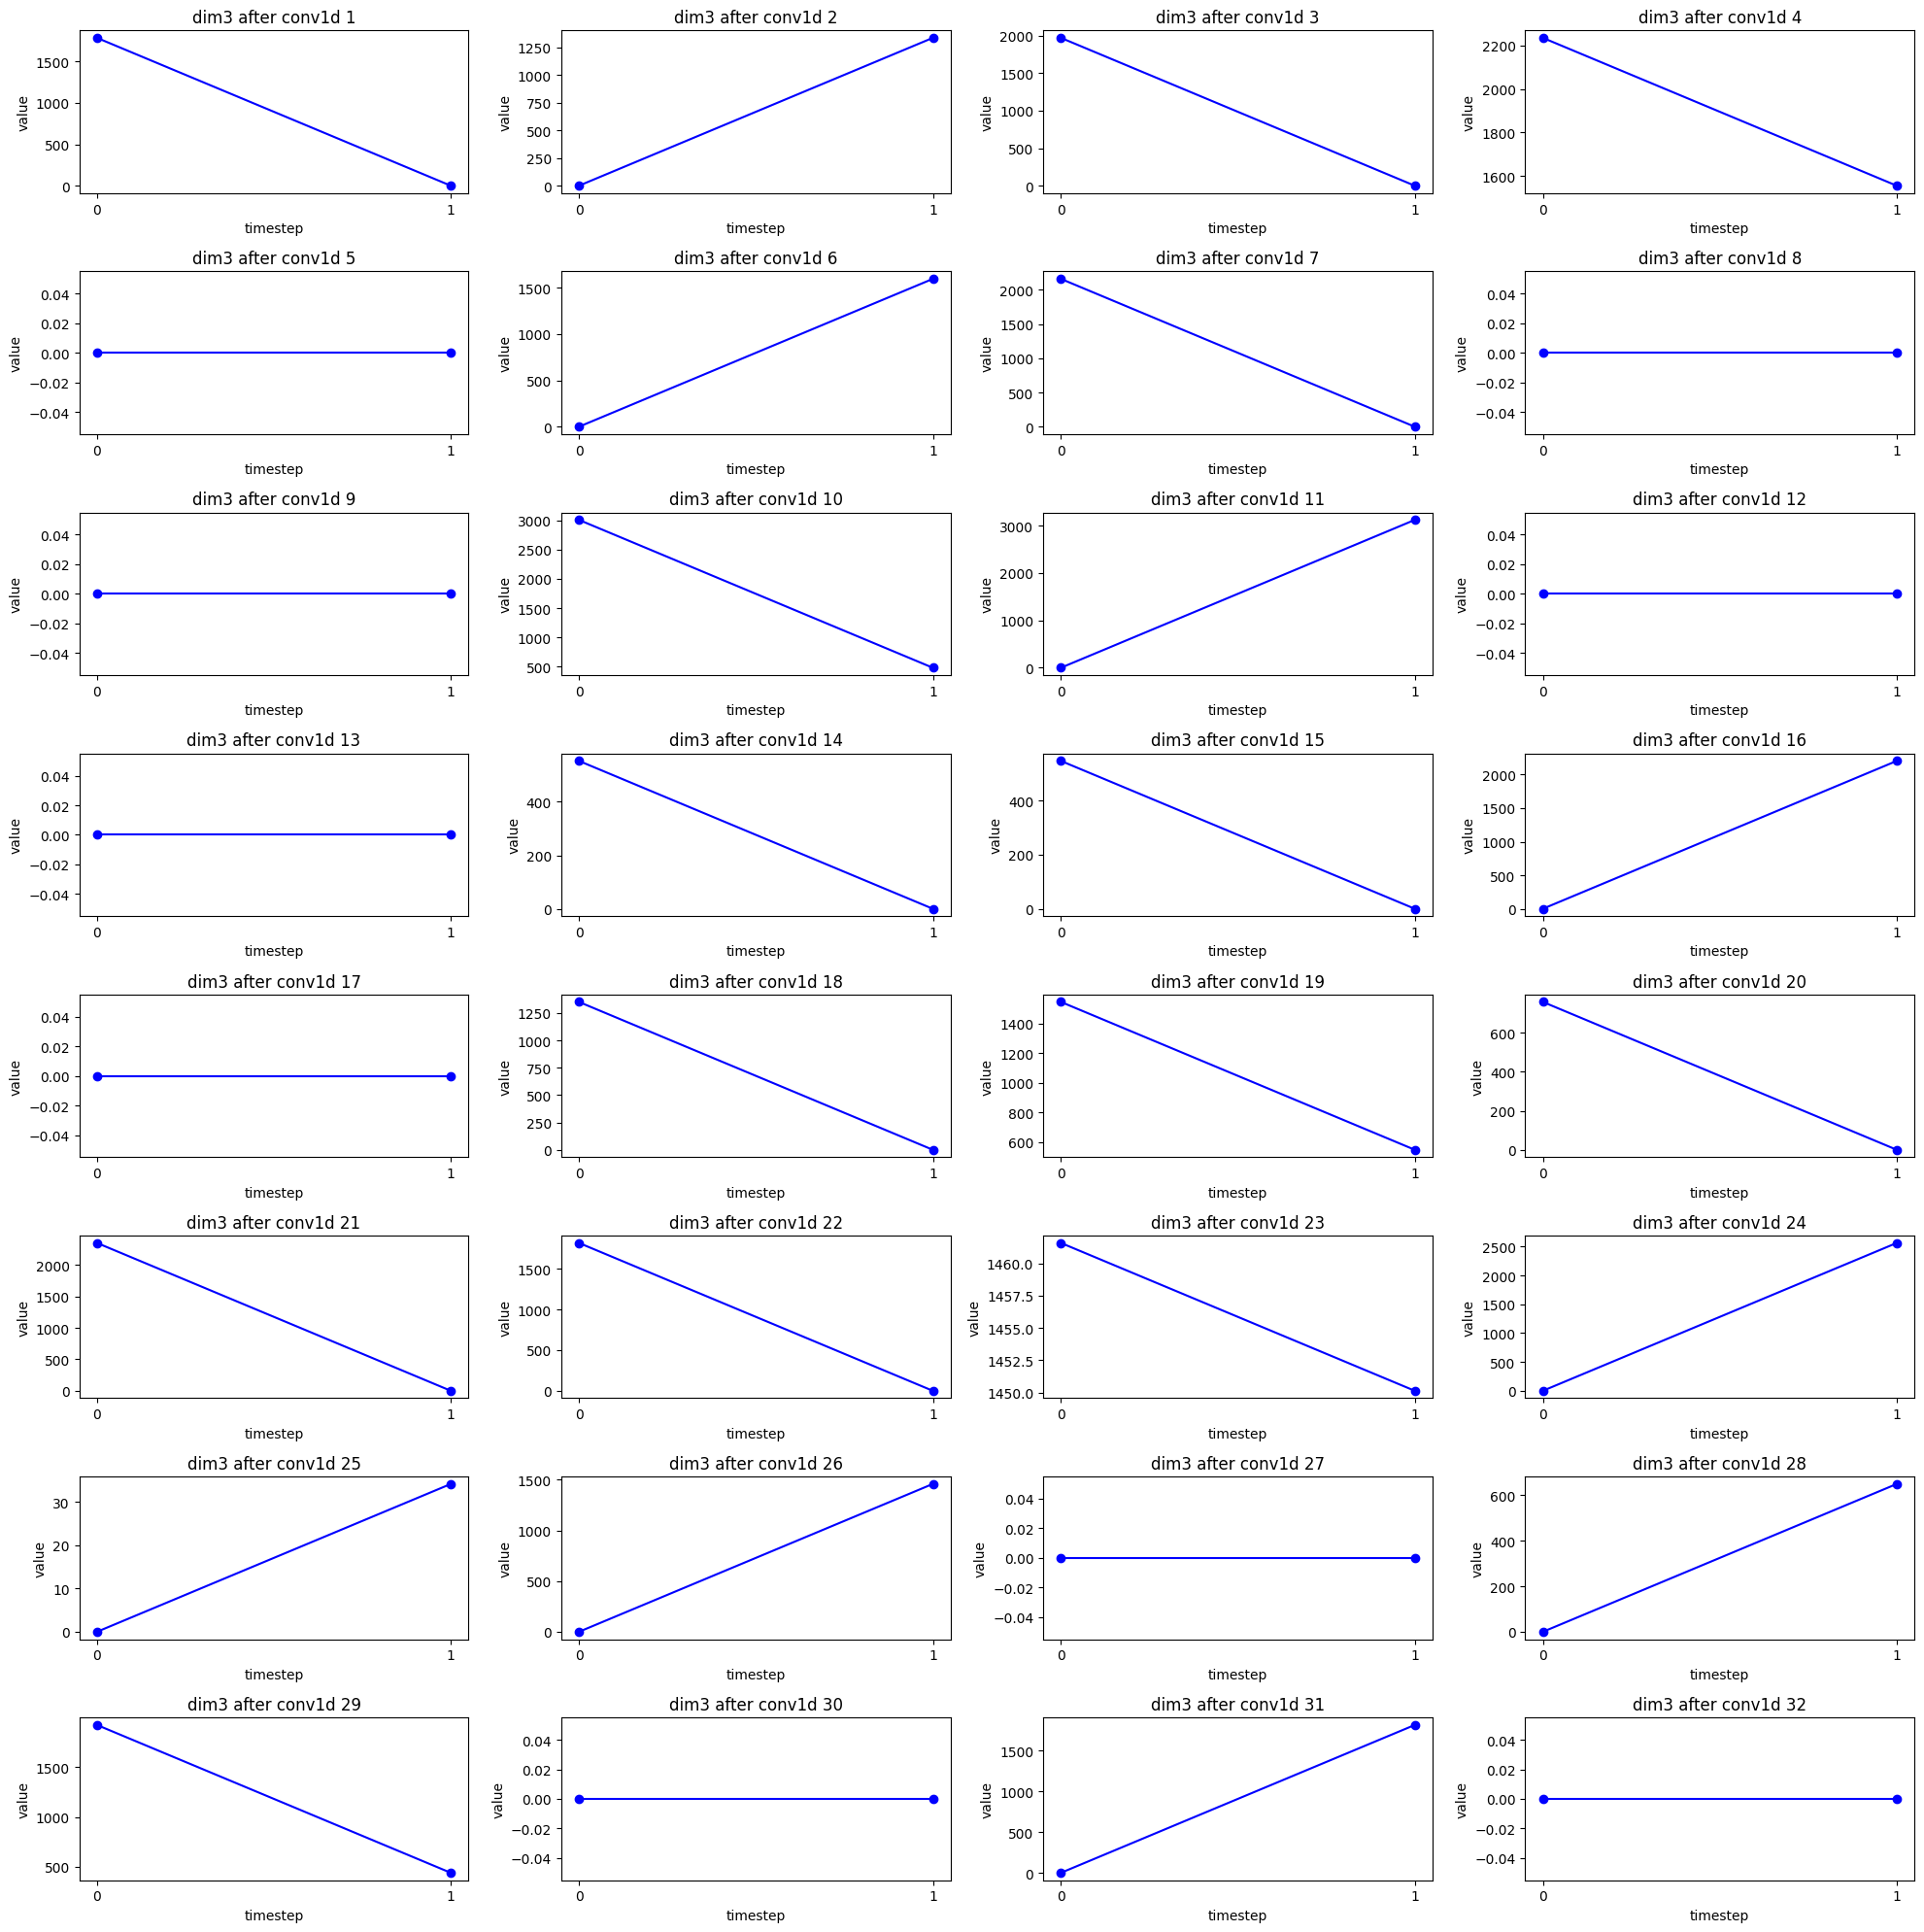

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


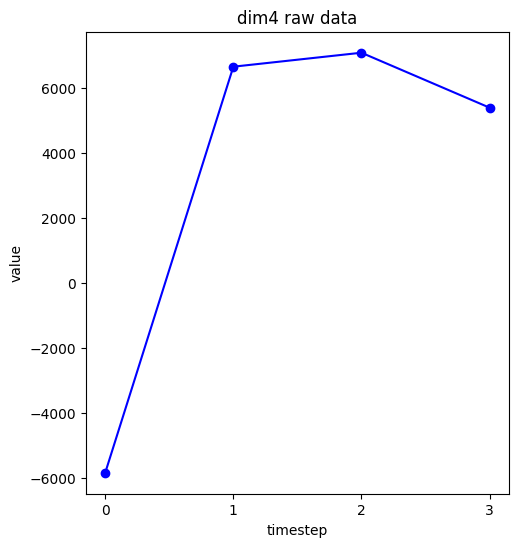

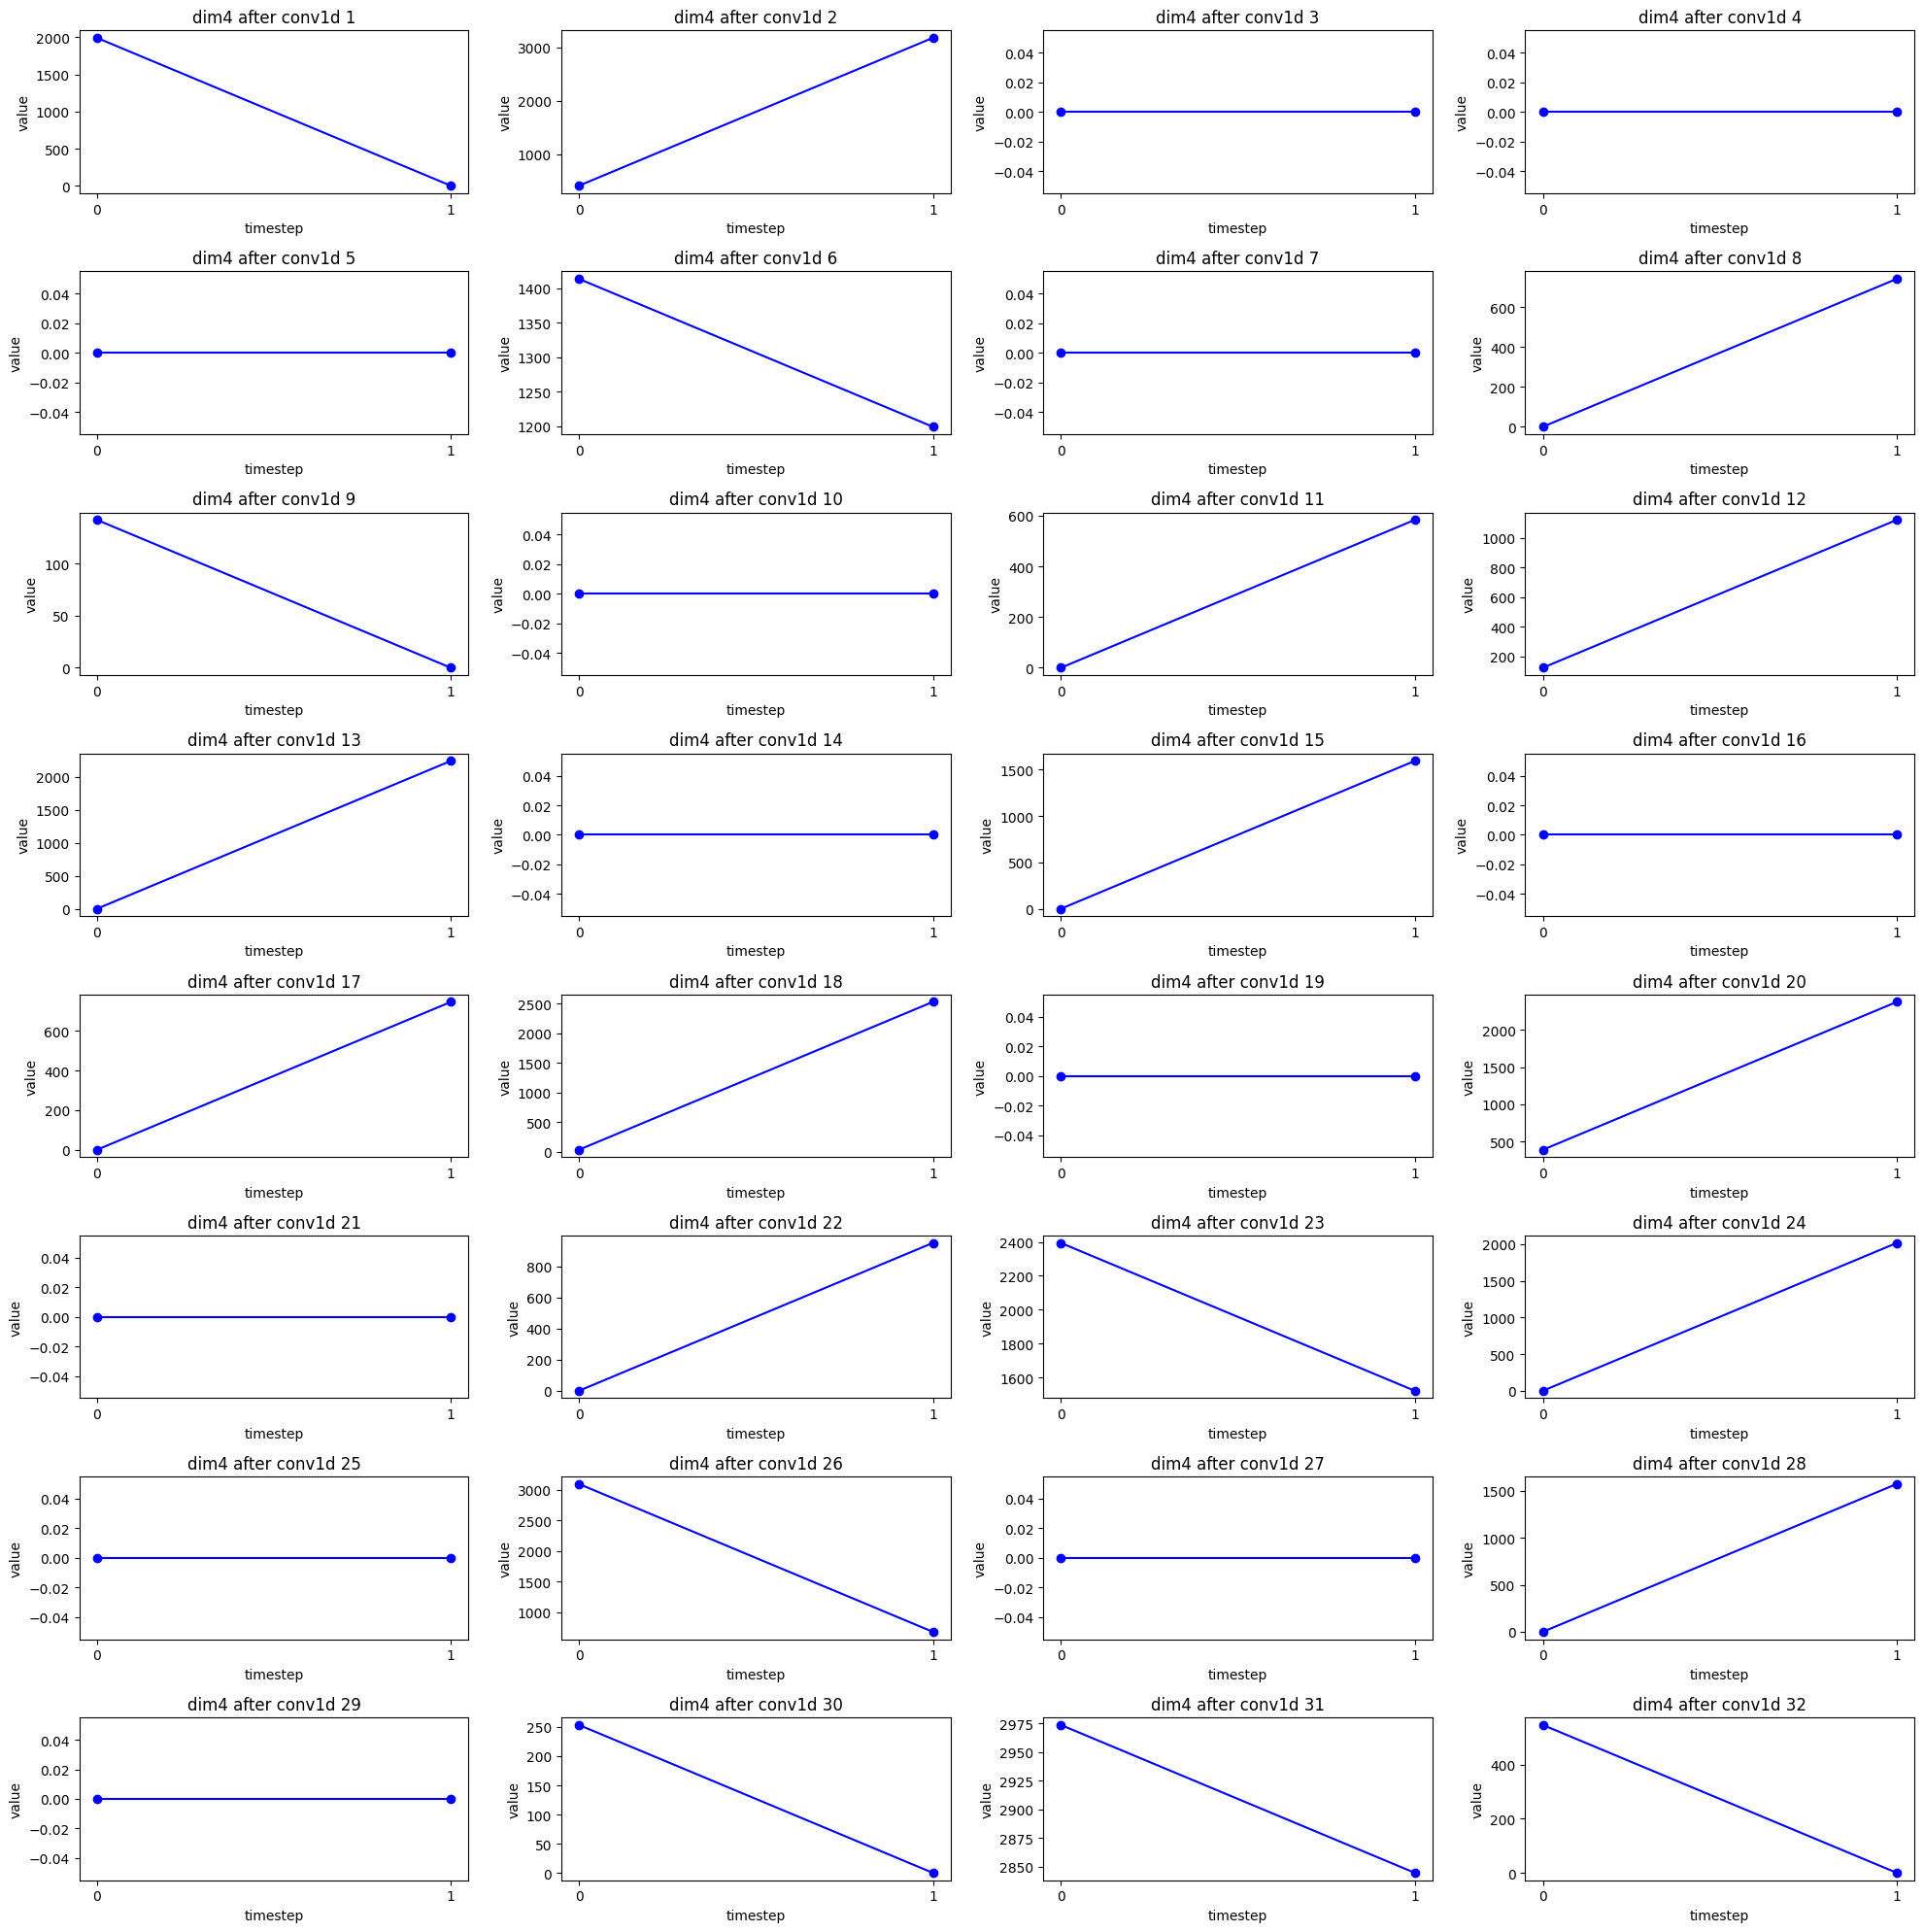

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


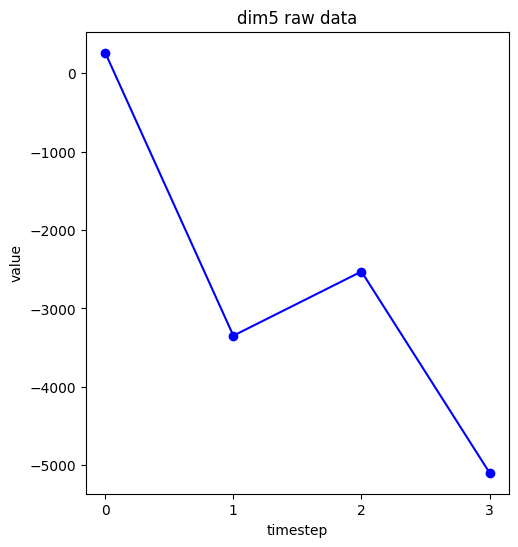

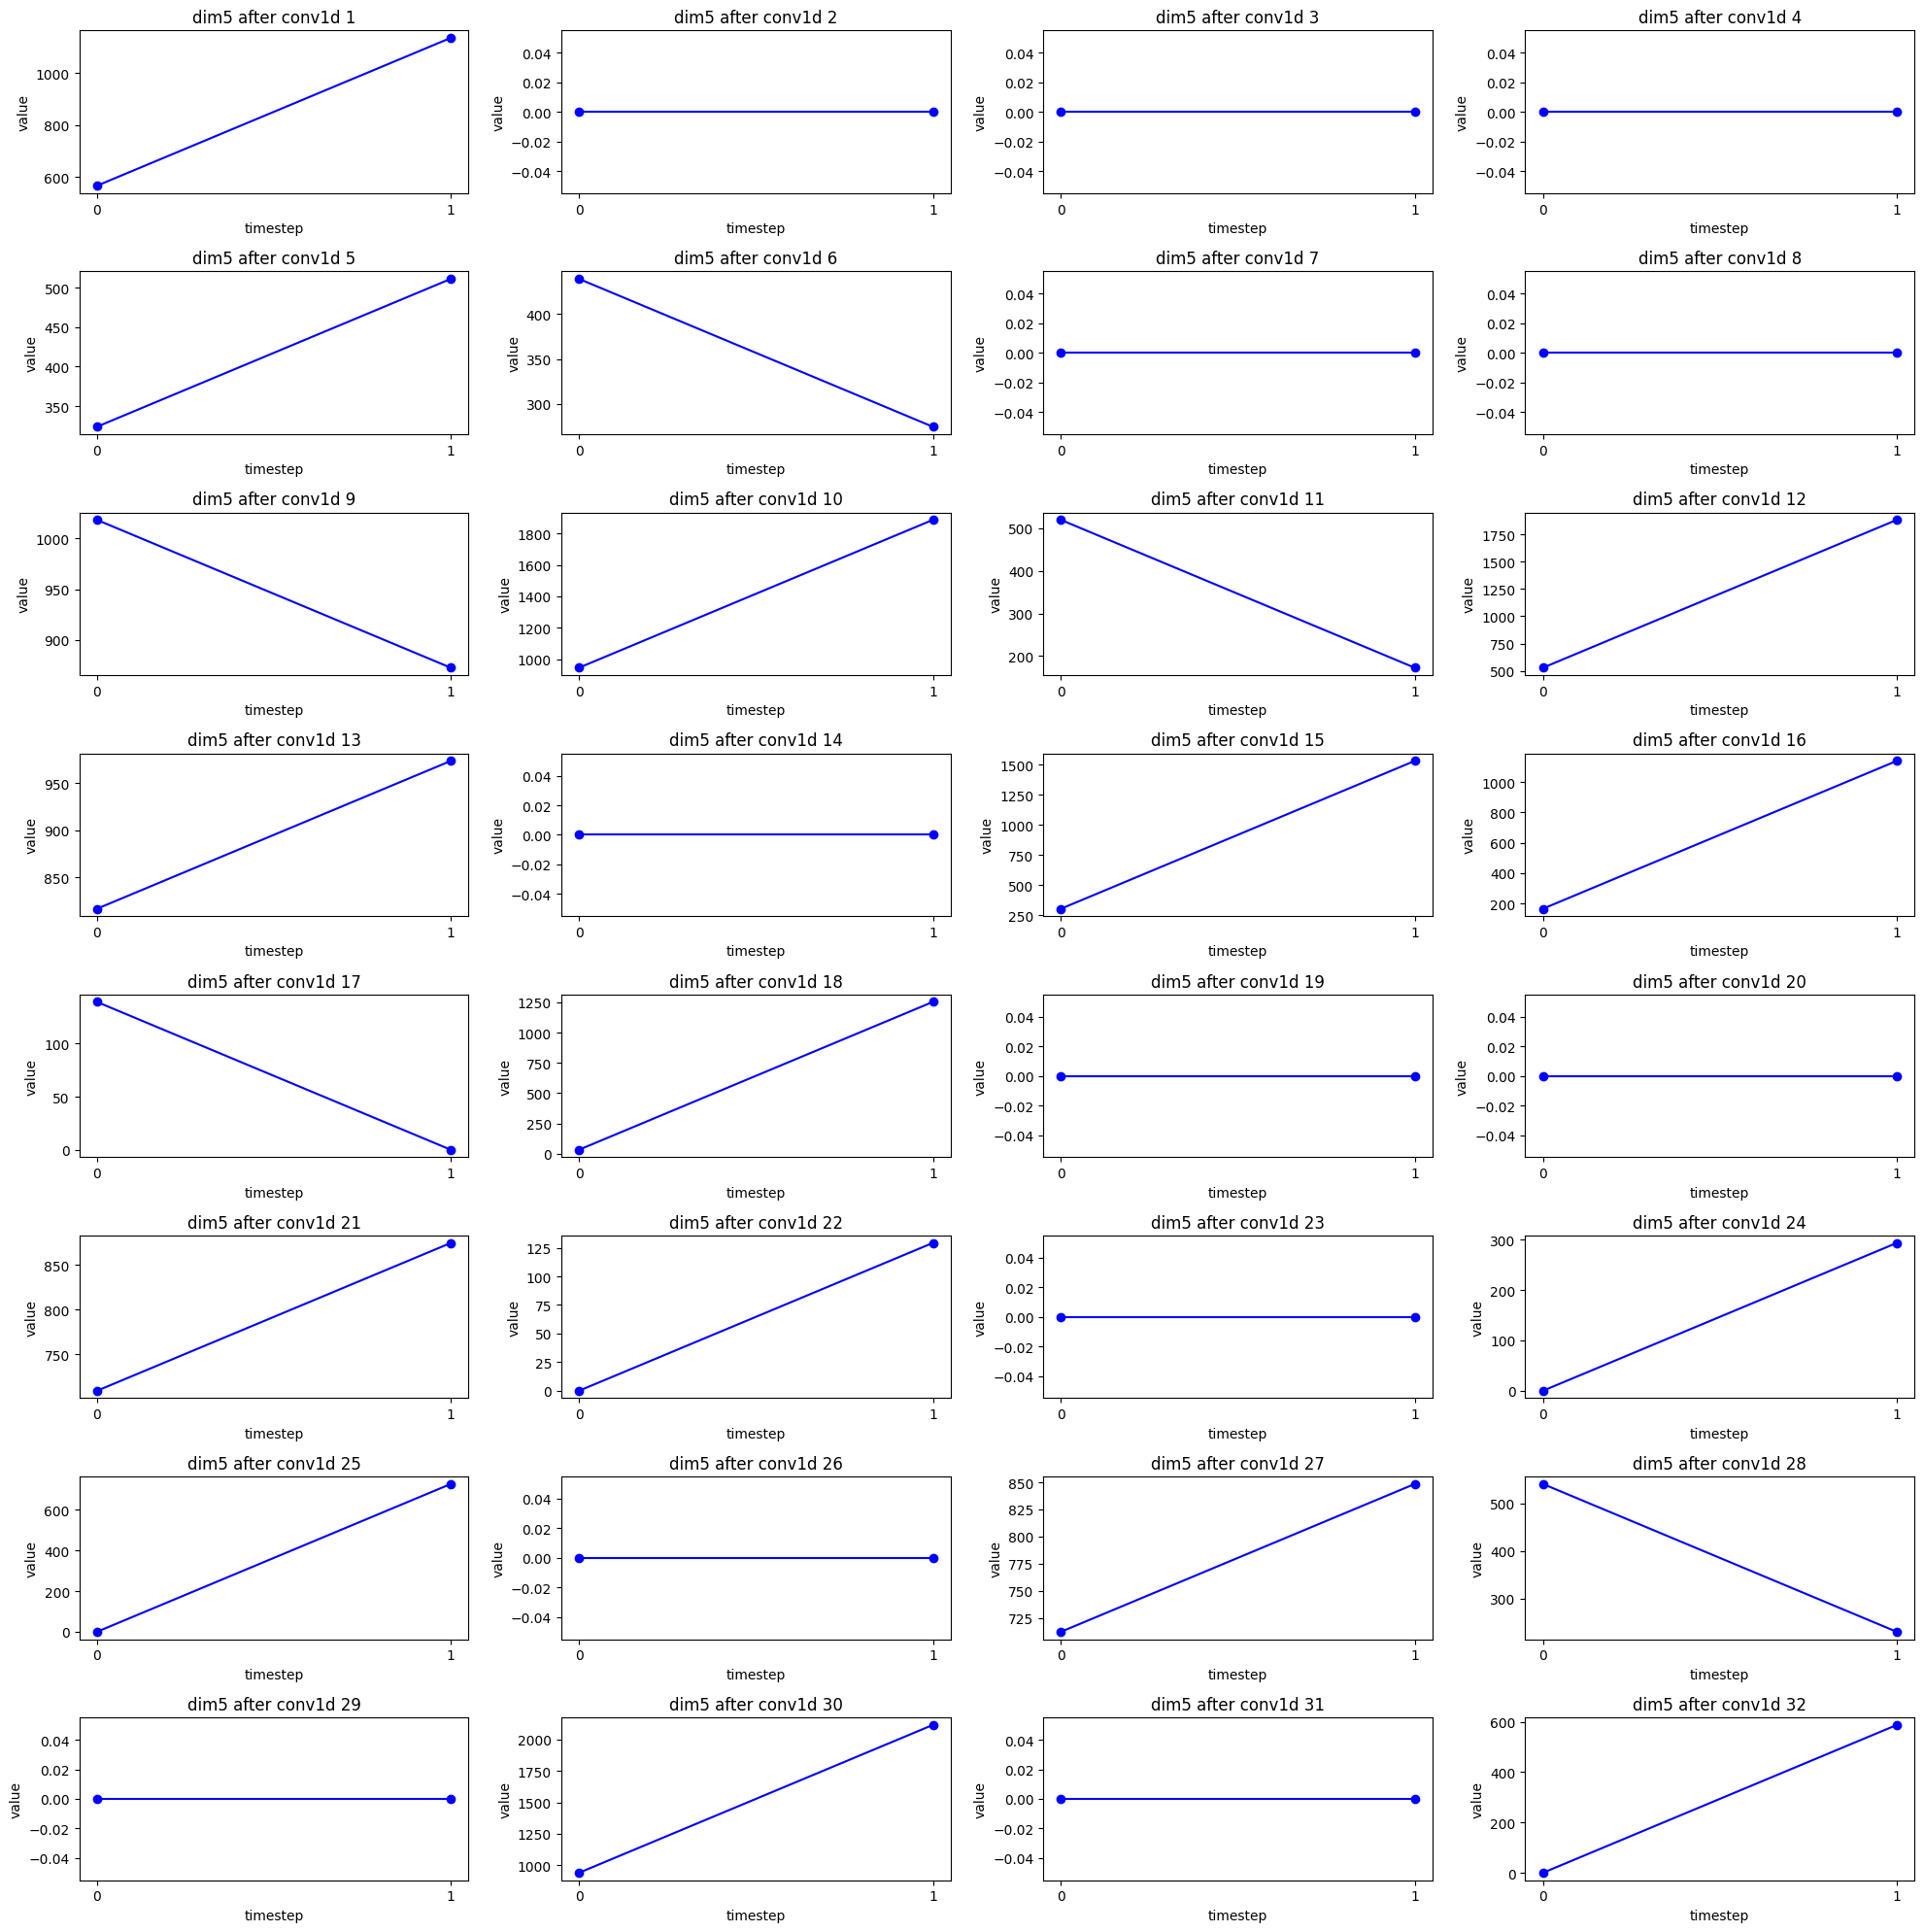

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


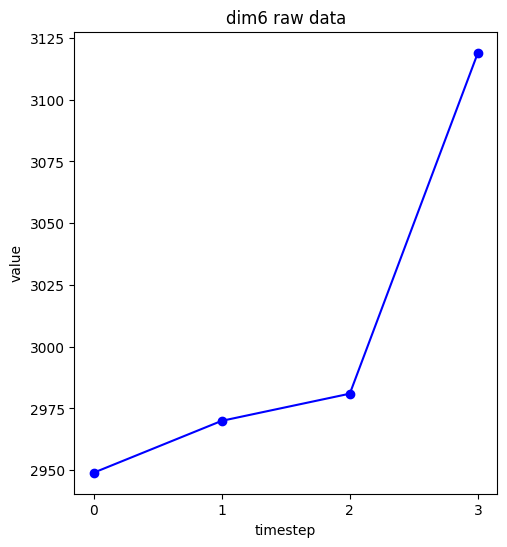

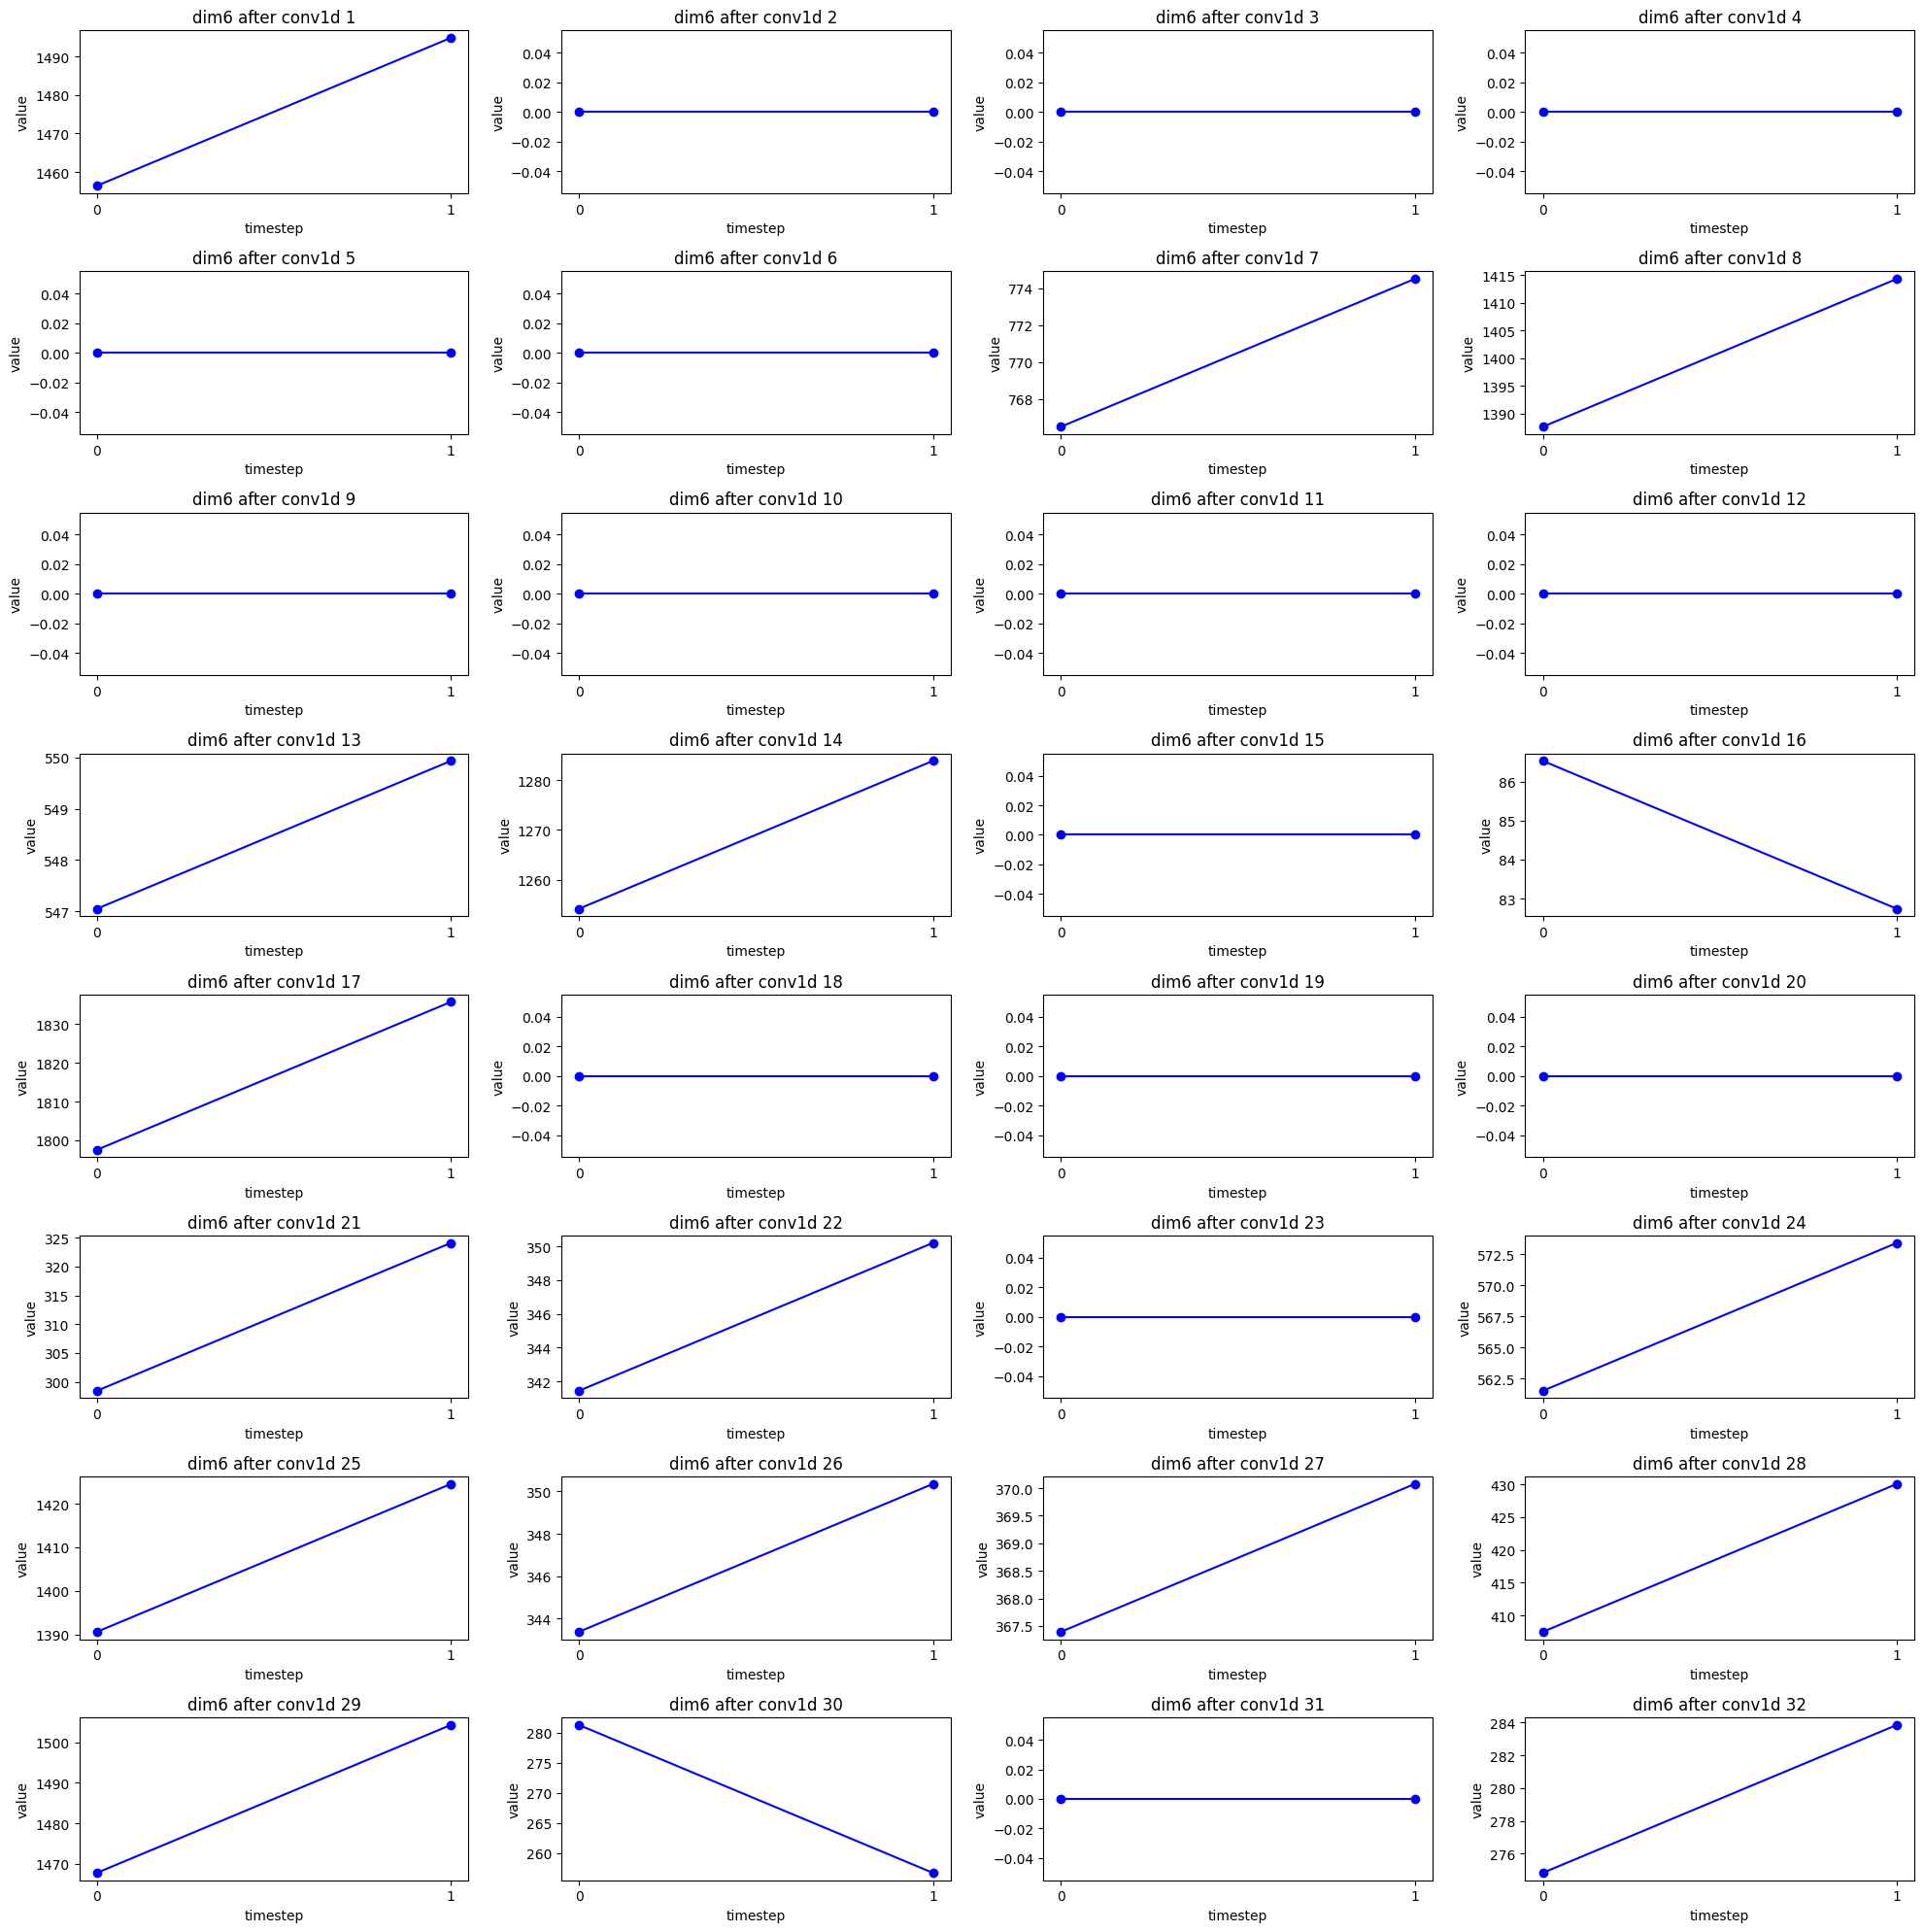

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


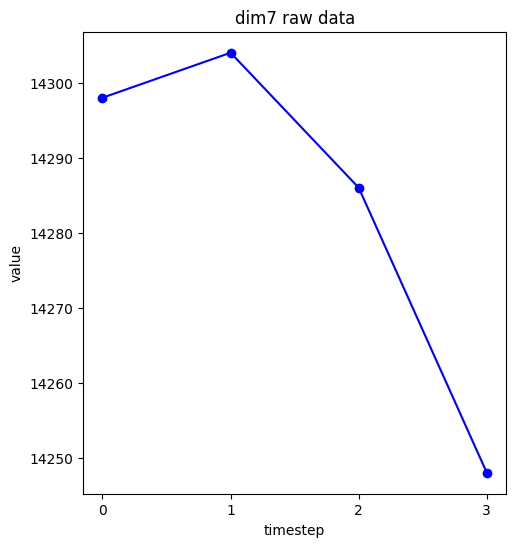

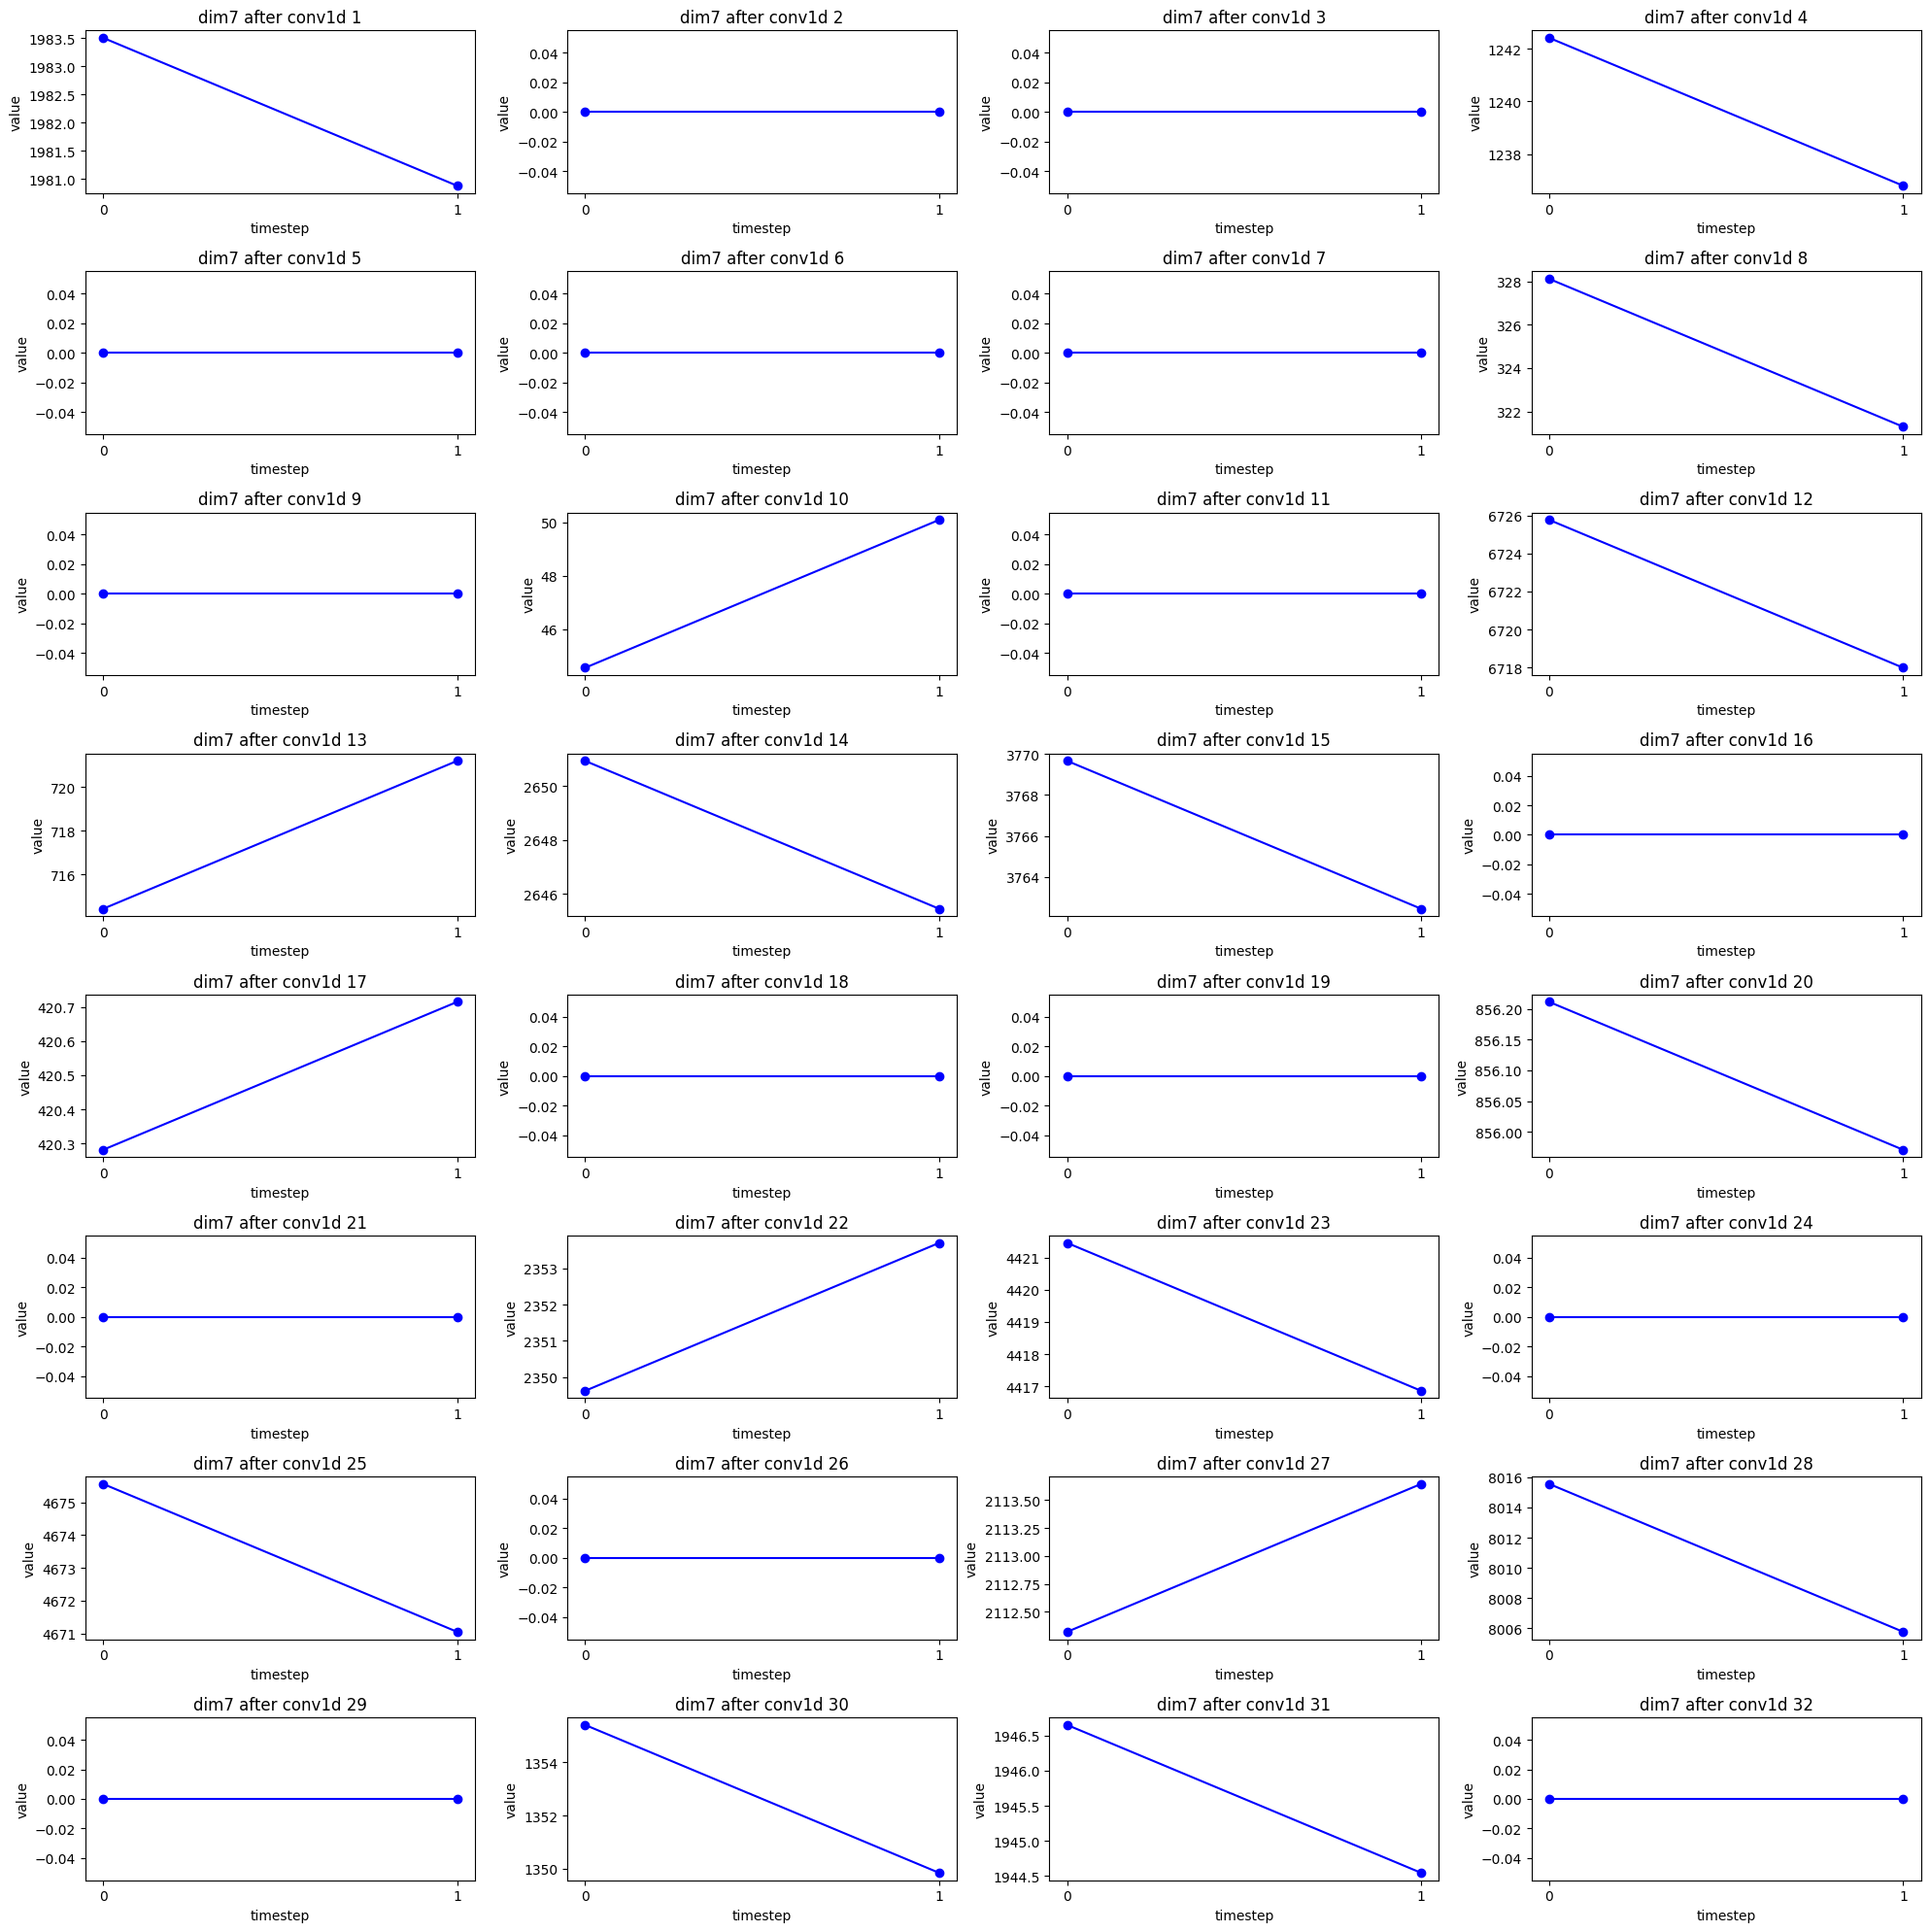

In [15]:
for i in range (8):
    conv1d_result(X_train[:, :, i:i+1],title=f'dim{i}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.9761 - loss: 3.2505   
Test Loss: 3.9083
Test Accuracy: 0.9665
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


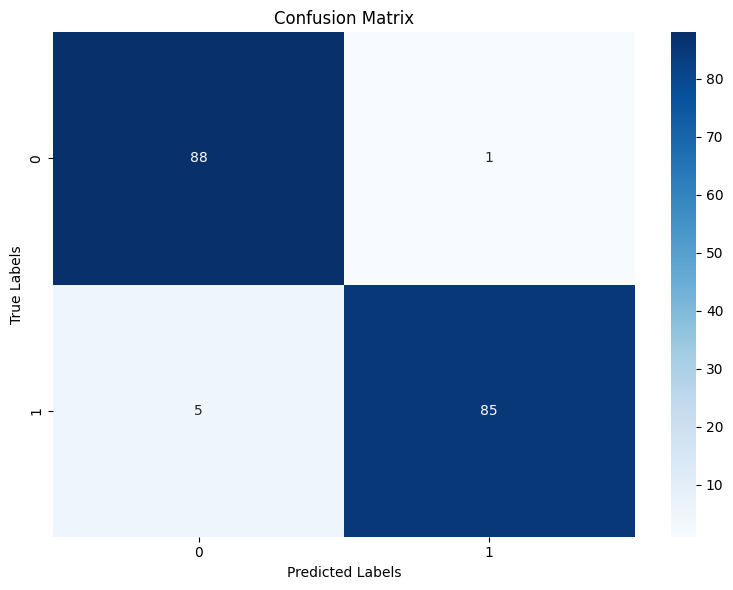

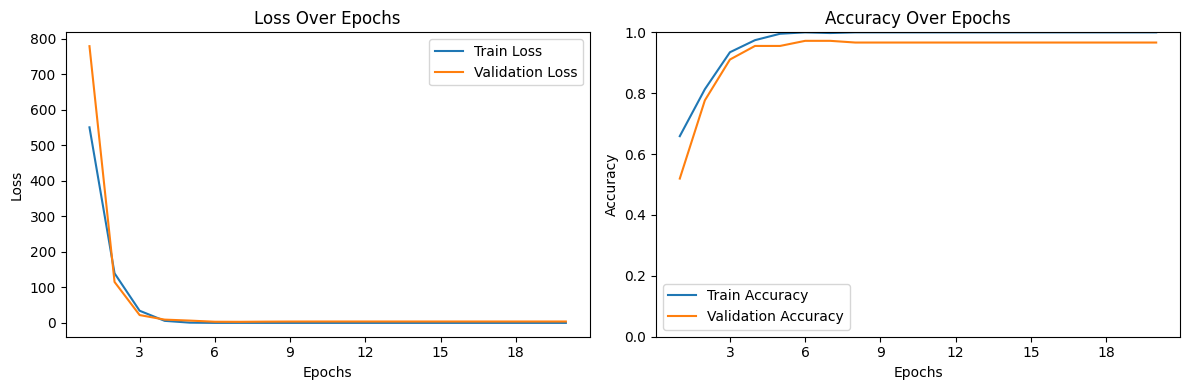

In [18]:
from keras.layers import Input, Conv1D, Add, Dense, Flatten, Lambda, Concatenate, Dropout
from keras.models import Model

# 定義輸入層
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# 建立分支卷積
branches = []
for i in range(X_train.shape[2]):
    # 提取第 i 個特徵的子序列 (形狀: (sequence_length, 1))
    single_feature = Lambda(
        lambda x, idx=i: x[:, :, idx:idx+1],
        output_shape=(X_train.shape[1], 1)
    )(input_layer)
    
    # 對該特徵進行卷積處理
    branch = Conv1D(filters=32, kernel_size=3, activation='relu')(single_feature)
    branches.append(branch)

# 合併所有分支的結果
merged = Concatenate()(branches)

# 將結果展平
flatten = Flatten()(merged)

# 50% dropout rate
dropout = Dropout(0.5)(flatten)  

# 假設二分類問題
output = Dense(1, activation='sigmoid')(flatten)  

# 定義模型
model = Model(inputs=input_layer, outputs=output)

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 檢視模型結構
# model.summary()

# 訓練神經網路並保存歷史數據
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_test, y_test))


# 評估模型在測試集上的表現
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 畫圖
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # 二分類閾值設定為 0.5
print_result(y_test, y_pred, history, [0,1])
